<a href="https://colab.research.google.com/github/lynhtrann22/personal_project/blob/main/choice_model_of_beer_preferences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A discrete choice analysis of sustainable beer customers & preferences

*Note: biogeme typically returns an error when importing for us the first time we run it, so please just do Runtime > Restart Runtime and it should work from there.*



####1. **Introduction**




Breweries are adopting more sustainable practices year-on-year and selling sustainable products in the face of climate change. These breweries desire to define a target market that best resonates with their new sustainable products and what attributes of their product best resonate with this audience. Answering these problems allow them increase their market share by gaining new customers, influence existing customers to buy more, and help achieve their internal sustainable goals while maintaining their bottom line.

As a demonstrative exercise, our study uses discrete choice modelling to inform a brewery's targeted advertising of a new sustainable beer, as well as the attributes of its new sustainable beer. In the first section of this study, we analyse the survey data to inform the likelihood of purchasing sustainable beer according to the characteristics of the individual with the choice outcome of the respondent. Secondly, we asked and analysed some research questions about specific features of the survey. Thirdly, we analysed the features contributing to spending on a 6-pack of beer, regardless of sustainability. Thirdly, we propose an experiment that studies the attributes of a sustainable beer that resonates with various customers.



The data is sourced from Carley and Yahng's article (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0204917). The researchers use the survey data to predict the willingness to pay for sustainable beer. The data was sourced from Amazon's Mechanical Turk, which opens itself to measurement bias in terms of using a sample that is not representative of the population. However, determining the impact of measurement bias is ignored for the purpose of this study. The survey contains 106 question columns answered by 1,206 respondents, though notably half of the respondents were provided with the same few questions in the context of their hypothetical ideal beer and the other half of their existing beer preference, denoted by the WTP 1 and 2 classifications of questions. The source article determined that there was no statistical difference between the groups, so for this study's purpose, the groups were combined. This required the combination of a few question variables.

The questions and their answers can be viewed in section 2.b. below, contained within the 'question_cols_mapping' dictionary.


####2. **Imports**

##### 2.a. **Import libraries & dataset**

In [ ]:
!pip install biogeme
import pandas as pd
import matplotlib.pyplot as plt
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.expressions as exp
import biogeme.tools as tools
import biogeme.distributions as dist
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [ ]:
# Google Drive shareable link
url = 'https://drive.google.com/uc?id=1dnzTqlmcvXee83mOHocvkaSEf0tqz5Pt'
df = pd.read_csv(url)
df

,Date,ID,duration,finished,age,state,QID4,QID5,QID6_TEXT,QID7,...,QID30a,QID30_6_TEXT,QID31,QID32_TEXT,QID88,QID35,QID36,QID37,QID38,QID38_4_TEXT
0,10/7/16,1,651,1,62,34,1,1,14,1,...,1.0,NaN,6,1.0,4,2,4,2.0,3.0,NaN
1,10/7/16,2,742,1,25,44,1,1,3,1,...,1.0,NaN,1,4.0,1,7,7,6.0,1.0,NaN
2,10/7/16,3,706,1,64,39,2,2,9,1,...,1.0,NaN,3,1.0,2,6,4,5.0,2.0,NaN
3,10/7/16,4,574,1,39,11,3,2,2,5,...,1.0,NaN,1,4.0,7,2,2,4.0,3.0,NaN
4,10/7/16,5,253,1,37,36,1,1,35,1,...,1.0,NaN,1,2.0,2,2,6,6.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,10/7/16,1202,406,1,69,6,2,2,4,1,...,2.0,NaN,1,2.0,7,4,5,2.0,3.0,NaN
1202,10/7/16,1203,493,1,28,14,1,2,8,1,...,1.0,NaN,1,2.0,3,1,3,4.0,2.0,NaN
1203,10/7/16,1204,709,1,30,26,3,2,4,2,...,1.0,NaN,6,3.0,4,2,5,2.0,NaN,NaN
1204,10/7/16,1205,580,1,37,6,2,2,2,5,...,1.0,NaN,1,5.0,1,3,5,6.0,3.0,NaN


##### 2.b. **Listing the dictionary of questions & answers**

In [ ]:
question_cols_mapping = {'ID':'respondant ID',
                         'duration':'time it took to complete survey',
                         'finished':'whether or not they completed the survey',
                         'age':'What is your age?',
                         'state':'In which U.S state do you currently live?',
                         'QID4':['On average, how frequently do you drink one or more beers in a day?',
                                    {1:'4+ times a week',2:'1-3 times a week',3:'1-3 times a month',
                                     4:'1 time every other month or less',5:'Never'}],#4&5 were removed from survey results
                         'QID5':['Considering the beer that you drink, about how often are you the one who actually buys the beer?',
                                 {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],#4,5 removed from survey
                         'QID6_TEXT':['About how many beers have you consumed in the past week?'],
                         'QID7':['Where do you most often drink beer?',
                                 {1:'Home',2:'Restaurants',3:'Bars',4:'Brewpubs or breweries',
                                  5:'Parties, gatherings, or other social events',
                                  6:'Other'}],#we ignore the other results
                         'QID8a':['Which style(s) of beer do you buy most often (select up to 3)',
                                  {1:'Light/pale American larger',2:'Dark larger',3:'Pilsner',
                                   4:'Pale ale',5:'IPA',6:'Dark ale',7:'Stout',8:'Bock',
                                   9:'Wheat',10:'Barleywine',11:'Scottish ale',12:'Porter',
                                   13:'Belgian',14:'Other'}],
                         'QID8b':['Which style(s) of beer do you buy most often (select up to 3)',
                                  {1:'Light/pale American larger',2:'Dark larger',3:'Pilsner',
                                   4:'Pale ale',5:'IPA',6:'Dark ale',7:'Stout',8:'Bock',
                                   9:'Wheat',10:'Barleywine',11:'Scottish ale',12:'Porter',
                                   13:'Belgian',14:'Other'}],
                         'QID8c':['Which style(s) of beer do you buy most often (select up to 3)',
                                  {1:'Light/pale American larger',2:'Dark larger',3:'Pilsner',
                                   4:'Pale ale',5:'IPA',6:'Dark ale',7:'Stout',8:'Bock',
                                   9:'Wheat',10:'Barleywine',11:'Scottish ale',12:'Porter',
                                   13:'Belgian',14:'Other'}],
                         'QID9_1':['How frequently you purchase domestic craft beer',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',
                                     5:'Never'}],
                         'QID9_2':['How frequently you purchase domestic mass-produced beer',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',
                                     5:'Never'}],
                         'QID9_3':['How frequently you purchase imported beer',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',
                                     5:'Never'}],
                         'QID75':['How often do you brew your own beer?',
                                  {1:'Several times a year',2:'A few times a year',
                                   3:'About once a year',4:'Just tried it once or twice',
                                   5:'Never'}],
                         'QID10':['When you buy beer at the store, how much do you usually spend on a 6-pack?',
                                  {1:'$3-$5.99',2:'$6-7.99',3:'$8-$9.99',4:'$10-$12',5:'I do not buy beer in a 6-pack'}],
                         'QID81':['Imagine yourself standing at the store in front of a full shelf of different beer options, and you are looking to buy one of them. Besides cost, what factor do you think would most influence the decision that you make about which to buy?',
                                  {1:'Something new that I have never had before',
                                   2:'Graphics and visuals on the packaging',
                                   3:'Reputation of the brewery',
                                   4:'If the beer is a favourite',
                                   5:'If a beer is local',
                                   6:'Word of mouth from others about what is good',
                                   7:'Other'}],#other results ignored
                         'QID48_TEXT':['WTP1. Please think about a beer you really like to drink. What is the brand and name of this beer?'],
                         'QID48_type':['WTP1. Not sure what this is'],
                         'QID76':['WTP1. SizePackage. What size package does this preferred beer come in?',
                                  {1:'single beer',2:'4-pack',3:'6-pack',4:'12-pack',5:'24-pack',6:'other'}],#other results ignored
                         'QID55_TEXT':['WTP1. Approximately how much is a SizePackage of this beer? Please enter the price in dollars and cents'],
                         'QID52':['WTP1. If the beer you like to drink were brewed using [sustainable] practices would you be willing to pay more',
                                  {1:'No',2:'Yes'}],
                         'QID51_TEXT':['WTP1. If QID52=Yes, how much more would you be willing to pay? (Unreliable, clear data entry errors)'],
                         'QID80':['WTP1. If a beer was brewed sustainably, would you be more or less likely to buy it over similar beers, assuming no change in price?',
                                  {1:'Much more likely',2:'Somewhat more likely',3:'Neither more nor less likely',
                                   4:'Somewhat less likely',5:'Much less likely'}],
                         'QID40':['WTP2. For your ideal beer, rank the colour 1 to 10 (care vs dont)',{1:'Enter number',2:"Don't care"}],
                         'QID40_1_TEXT':['WTP2. For your ideal beer, rank the colour 1 to 10',
                          {1:'Very light/pale',10:'Very dark'}],
                         'QID41':['WTP2. For your ideal beer, rank how hoppy the beer is (care vs dont)',{1:'Enter number',2:"Don't care"}],
                         'QID41_1_TEXT':['For your ideal beer, rank how hoppy the beer is',
                                        {1:'no hops flavour',10:'extremely hoppy'}],
                         'QID56':['WTP2. For your ideal beer, rank how malty the beer is (care vs dont)',{1:'Enter number',2:"Don't care"}],
                         'QID56_1_TEXT':['For your ideal beer, rank how malty the beer is',
                                        {1:'no malt flavour',10:'extremely malty'}],
                         'QID77':['WTP2. SizePackage. What size package does this preferred beer come in?',
                                  {1:'single beer',2:'4-pack',3:'6-pack',4:'12-pack',5:'24-pack',6:'other'}],#other results ignored
                         'QID43_TEXT':['WTP2. If you found your ideal beer on the shelf at a store, what is the most you would pay for [ideal sizepackage] of it? Enter in dollars and cents'],
                         'QID45':['WTP2. If the beer you like to drink were brewed using [sustainable] practices would you be willing to pay more',
                                  {1:'No',2:'Yes'}],
                         'QID46_TEXT':['WTP1. If QID52=Yes, how much more would you be willing to pay? (Unreliable, clear data entry errors)'],
                         'QID73':['WTP2. If a beer was brewed sustainably, would you be more or less likely to buy it over similar beers, assuming no change in price?',
                                  {1:'Much more likely',2:'Somewhat more likely',3:'Neither more nor less likely',
                                   4:'Somewhat less likely',5:'Much less likely'}],
                         'QID79g':['Aspects valued most in a brewery',
                                   {1:"Whether it's local",2:'Sustainability practices',3:'Community involvement',
                                    4:'Independently owned',5:'Long history or tradition',6:'Value-conscious',
                                    7:'Other',8:"I don't go to breweries"}],
                         'QID79f':['Aspects valued most in a brewery',
                                   {1:"Whether it's local",2:'Sustainability practices',3:'Community involvement',
                                    4:'Independently owned',5:'Long history or tradition',6:'Value-conscious',
                                    7:'Other',8:"I don't go to breweries"}],
                         'QID79e':['Aspects valued most in a brewery',
                                   {1:"Whether it's local",2:'Sustainability practices',3:'Community involvement',
                                    4:'Independently owned',5:'Long history or tradition',6:'Value-conscious',
                                    7:'Other',8:"I don't go to breweries"}],
                         'QID79d':['Aspects valued most in a brewery',
                                   {1:"Whether it's local",2:'Sustainability practices',3:'Community involvement',
                                    4:'Independently owned',5:'Long history or tradition',6:'Value-conscious',
                                    7:'Other',8:"I don't go to breweries"}],
                         'QID79c':['Aspects valued most in a brewery',
                                   {1:"Whether it's local",2:'Sustainability practices',3:'Community involvement',
                                    4:'Independently owned',5:'Long history or tradition',6:'Value-conscious',
                                    7:'Other',8:"I don't go to breweries"}],
                         'QID79b':['Aspects valued most in a brewery',
                                   {1:"Whether it's local",2:'Sustainability practices',3:'Community involvement',
                                    4:'Independently owned',5:'Long history or tradition',6:'Value-conscious',
                                    7:'Other',8:"I don't go to breweries"}],
                         'QID79a':['Aspects valued most in a brewery',
                                   {1:"Whether it's local",2:'Sustainability practices',3:'Community involvement',
                                    4:'Independently owned',5:'Long history or tradition',6:'Value-conscious',
                                    7:'Other',8:"I don't go to breweries"}],
                         'QID47':['How knowledgeable would you say you are about types of beer, as well as beer in general?',
                                   {1:"Very knowledgable",2:'Somewhat knowledgable',3:'Not too knowledgable',
                                    4:'A little knowledgable',5:"I haven't really thought about this topic"}],
                         'QID13_1':['How frequently you engage in: developing your career',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_2':['How frequently you engage in: playing sports, exercise, or recreation',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_3':['How frequently you engage in: helping the environment',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_4':['How frequently you engage in: enjoying nature and the outdoors',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_5':['How frequently you engage in: religious or spiritual practices',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_6':['How frequently you engage in: researching or trying new technology',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_7':['How frequently you engage in: How frequently you engage in: school, lectures, or other education',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_8':['How frequently you engage in: How frequently you engage in: shopping',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_8':['How frequently you engage in: socialising with others',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_9':['How frequently you engage in: socialising with others',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_10':['How frequently you engage in: taking care of/spending time with family',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_11':['How frequently you engage in: using the internet for fun or leisure',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_12':['How frequently you engage in: watching tv or movies',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_13':['How frequently you engage in: volunteering or donating to charity',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID13_13':['How frequently you engage in: volunteering or donating to charity',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         'QID14':['How concerned are you about environmental issues?',
                                  {1:'Not at all concerned',5:'Very concerned'}],
                         'QID14':['How concerned are you about environmental issues?',
                                  {1:'Not at all concerned',5:'Very concerned'}],
                         'QID17':['I purchase environmentally-friendly or “green"products when the option is available (1 always - 5 rarely)',
                                  {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         'QID16_1':['How frequently you: compost waste',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         'QID16_2':['How frequently you: use your own bad instead of plastic or paper provided by a store',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         'QID16_3':['How frequently you: purchase organically grown food?',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         'QID16_4':['How frequently you: purchase recycled paper products?',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         'QID16_5':['How frequently you: turn off the water faucet while brushing your teeth?',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         'QID16_6':['How frequently you: keep heating low to save energy?',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         'QID16_7':['How frequently you: recycle?',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         'QID16_8':['How frequently you: buy from local stores?',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         'QID18':['My choices as a consumer will have a direct impact on the environment',
                                    {1:'Strongly agree',2:'Agree',3:'Somewhat agree',
                                     4:'Neither agree nor disagree',5:'Somewhat disagree',6:'Disagree',
                                     7:'Strongly disagree'}],
                         'QID20':['Companies have the responsibility to make all of their products more environmentally-friendly',
                                    {1:'Strongly agree',2:'Agree',3:'Somewhat agree',
                                     4:'Neither agree nor disagree',5:'Somewhat disagree',6:'Disagree',
                                     7:'Strongly disagree'}],
                         'QID22_1':['How strongly do you agree or disagree: there are no limits to growth for nations like the united states',
                                    {1:'Strongly agree',2:'Agree',3:'Somewhat agree',
                                     4:'Neither agree nor disagree',5:'Somewhat disagree',6:'Disagree',
                                     7:'Strongly disagree'}],
                         'QID22_2':['How strongly do you agree or disagree: modifying the environment seldom causes serious problems',
                                    {1:'Strongly agree',2:'Agree',3:'Somewhat agree',
                                     4:'Neither agree nor disagree',5:'Somewhat disagree',6:'Disagree',
                                     7:'Strongly disagree'}],
                         'QID22_3':['How strongly do you agree or disagree: science will help us to live without conservation',
                                    {1:'Strongly agree',2:'Agree',3:'Somewhat agree',
                                     4:'Neither agree nor disagree',5:'Somewhat disagree',6:'Disagree',
                                     7:'Strongly disagree'}],
                         'QID22_4':['How strongly do you agree or disagree: humans were created to rule over nature',
                                    {1:'Strongly agree',2:'Agree',3:'Somewhat agree',
                                     4:'Neither agree nor disagree',5:'Somewhat disagree',6:'Disagree',
                                     7:'Strongly disagree'}],
                         'QID22_5':['How strongly do you agree or disagree: the balance of nature is delicate and easily upset',
                                    {1:'Strongly agree',2:'Agree',3:'Somewhat agree',
                                     4:'Neither agree nor disagree',5:'Somewhat disagree',6:'Disagree',
                                     7:'Strongly disagree'}],
                         'QID22_6':['How strongly do you agree or disagree: the earth is like a space ship, with limited room and resources',
                                    {1:'Strongly agree',2:'Agree',3:'Somewhat agree',
                                     4:'Neither agree nor disagree',5:'Somewhat disagree',6:'Disagree',
                                     7:'Strongly disagree'}],
                         'QID22_7':['How strongly do you agree or disagree: plants and animals do not exist primarily for human use',
                                    {1:'Strongly agree',2:'Agree',3:'Somewhat agree',
                                     4:'Neither agree nor disagree',5:'Somewhat disagree',6:'Disagree',
                                     7:'Strongly disagree'}],
                         'QID22_8':['How strongly do you agree or disagree: one of the most important reasons for conservation is to preserve wild areas',
                                    {1:'Strongly agree',2:'Agree',3:'Somewhat agree',
                                     4:'Neither agree nor disagree',5:'Somewhat disagree',6:'Disagree',
                                     7:'Strongly disagree'}],
                         'QID22_9':['How strongly do you agree or disagree: technology will solve many environmental problems',
                                    {1:'Strongly agree',2:'Agree',3:'Somewhat agree',
                                     4:'Neither agree nor disagree',5:'Somewhat disagree',6:'Disagree',
                                     7:'Strongly disagree'}],
                         'QID22_10':['How strongly do you agree or disagree: exploitation of resources should be stopped',
                                    {1:'Strongly agree',2:'Agree',3:'Somewhat agree',
                                     4:'Neither agree nor disagree',5:'Somewhat disagree',6:'Disagree',
                                     7:'Strongly disagree'}],
                         'QID29alt':['What is your gender?',{1:'Male',2:'Female'}],
                         'QID29':['What is your gender?',{1:'Male',2:'Female'}],
                         #'QID30a':['What is your race?'],I reckon we can ignore
                         #b,c,30_6 the same
                         'QID31':['What is your marital status',
                                  {1:'Married',2:'Living as married',3:'Widowed',4:'Divorced',5:'Separated',6:'Single, never married'}],
                         'QID32_TEXT':['How many people, including children, live in your household?'],
                         #'QID88' is a question on tablets... i feel like we can ignore this...
                         'QID35':['When it comes to politics do you usually think of yourself as...',
                                  {1:'Extremely liberal',2:'Liberal',3:'Slightly liberal',
                                   4:'Moderate or middle of the road',5:'Slightly conservative',
                                   6:'Conservative',7:'Extremely conservative',8:"I haven't thought much about this"}],
                         'QID36':['What is the highest level of education you have completed?',
                                  {1:'Less than highschool',2:'High school/GED',3:'Some college',4:'2-year college degree',
                                   5:'4-year college degree',6:"Master's degree",7:'Professional degree (JD,MD)',
                                   8:'Doctoral degree'}],
                         'QID37':['Considering all sources which of the following best describes your total household income before taxes in 2015?',
                                  {1:'Under $15k',2:'$15k-$24,999',3:'$25k-$34,999',4:'$35k-$49,999',
                                   5:'$50k-$74,999',6:'$75k-$99,999',7:'$100k-$149,999',8:'$150k-$199,999',
                                   9:'$200k-$249,999',10:'Above $250k'}],
                         'QID38':['How would you describe your residence?',
                                  {1:'Rural',2:'Urban',3:'Suburban',4:'Other'}]
                         }


##### 2.c. **Auxilliary functions**

In [ ]:
#for the preferred beer, to transform them to dummy variables
def conditions(the_df,style):
  if (the_df['QID8a'] ==style) or (the_df['QID8b'] == style) or (the_df['QID8c'] == style):
      return 1
  else:
      return 0

In [ ]:
#for use with biogeme in general

def qbus_update_globals_bgm(pd_df):
   globals().update(db.Database('tmp_bg_bgm_for_glob', pd_df).variables)


def qbus_calc_accu_confusion(sim_probs, pd_df, choice_var):
  which_max = sim_probs.idxmax(axis=1)
  data = {'y_Actual':   pd_df[choice_var],
          'y_Predicted': which_max
        }

  df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
  confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
  accu = np.mean(which_max == pd_df[choice_var])
  return accu, confusion_matrix

In [ ]:
def qbus_likeli_ratio_test_bgm(results_complex, results_reference, signif_level):
  return tools.likelihood_ratio_test( (results_complex.data.logLike, results_complex.data.nparam),
                                     (results_reference.data.logLike, results_reference.data.nparam), signif_level)

In [ ]:
def qbus_estimate_ordered_bgm(V, ord_alt_ids, pd_df, tgtvar_name, modelname='ord_bgm'):
 bgm_db = db.Database(modelname + '_db', pd_df)
 globals().update(bgm_db.variables)

 taus_map = {ord_alt_ids[0]: exp.Beta('tau1', -1, None, None, 0) }
 i = 1
 for id in ord_alt_ids[1:-1]:
  taus_map[id] = taus_map[ ord_alt_ids[i-1] ] + exp.Beta('delta_'+ str(i + 1), i, 0, None, 0)
  i = i + 1

 alt_probs_map = {ord_alt_ids[0]: dist.logisticcdf( taus_map[ord_alt_ids[0] ] - V) }

 i = 1
 for id in ord_alt_ids[1:-1]:
  alt_probs_map[id] = dist.logisticcdf( taus_map[id] - V) - dist.logisticcdf( taus_map[ ord_alt_ids[i-1] ] - V)
  i = i + 1

 alt_probs_map[ord_alt_ids[i] ] = 1 - dist.logisticcdf( taus_map[ord_alt_ids[i-1]] - V)

 logprob = exp.log(exp.Elem(alt_probs_map, bgm_db.variables[tgtvar_name]))

 #logprob = models.loglogit (V , av_auto , bgm_db.variables[tgtvar_name] )
 bgm_model = bio.BIOGEME ( bgm_db, logprob )
 bgm_model.utility_dic = V
 bgm_model.ord_probs = alt_probs_map.copy()
 return bgm_model, bgm_model.estimate()

In [ ]:
#for the basic & complex models for research topic 1
def df1_buildmodel(V_model,df_1):
  #we have 5 categories technically, even though a couple of alternatives are less so 4 cut off points
  tau1 = exp.Beta('tau1', -1, None, None, 0)
  delta2 = exp.Beta('delta2', 1, 0, None, 0)
  tau2 = tau1 + delta2
  delta3 = exp.Beta('delta3', 2, 0, None, 0)
  tau3 = tau2 + delta3
  delta4 = exp.Beta('delta4', 3, 0, None, 0)
  tau4 = tau3 + delta4

  #mapping the cut offs and the probabilities
  alt_probs_map = {
      1: dist.logisticcdf(tau1 - V_model),
      2: dist.logisticcdf(tau2 - V_model) - dist.logisticcdf( tau1 - V_model),
      3: dist.logisticcdf(tau3 - V_model) - dist.logisticcdf( tau2 - V_model),
      4: dist.logisticcdf(tau4 - V_model) - dist.logisticcdf( tau3 - V_model),
      5: 1- dist.logisticcdf(tau4 - V_model)}

  logprob = exp.log(exp.Elem(alt_probs_map, QID80and73))

  #build & display the model
  pd.set_option('display.float_format', lambda x: '%.6f' % x)
  beers_db = db.Database('beers', df_1)
  biogeme  = bio.BIOGEME(beers_db, logprob)
  results = biogeme.estimate()
  display(results.getEstimatedParameters())

  #simulate to get predictions & assess model
  bgm_pred_model = bio.BIOGEME(beers_db, alt_probs_map)
  simulatedValues = bgm_pred_model.simulate(results.getBetaValues())
  predictions = simulatedValues.idxmax(axis="columns").copy()
  display(qbus_calc_accu_confusion(simulatedValues,df_1,"QID80and73")) # benchmark accuracy = 43% where 2 is guessed every time

  return(results)

In [ ]:
#for the basic & complex models for research topic 2
def df2_buildmodel(V_model,df_2):
  #we have 5 categories technically so 4 cut off points
  tau1 = exp.Beta('tau1', -1, None, None, 0)
  delta2 = exp.Beta('delta2', 1, 0, None, 0)
  tau2 = tau1 + delta2
  delta3 = exp.Beta('delta3', 2, 0, None, 0)
  tau3 = tau2 + delta3
  delta4 = exp.Beta('delta4', 3, 0, None, 0)
  tau4 = tau3 + delta4

  #mapping the cut offs and the probabilities
  alt_probs_map = {
      0: dist.logisticcdf(tau1 - V_model),
      1: dist.logisticcdf(tau2 - V_model) - dist.logisticcdf( tau1 - V_model),
      2: dist.logisticcdf(tau3 - V_model) - dist.logisticcdf( tau2 - V_model),
      3: dist.logisticcdf(tau4 - V_model) - dist.logisticcdf( tau3 - V_model),
      4: 1- dist.logisticcdf(tau4 - V_model)}

  logprob = exp.log(exp.Elem(alt_probs_map, QID10))

  #build & display the model
  pd.set_option('display.float_format', lambda x: '%.6f' % x)
  beers_db = db.Database('beers', df_2)
  biogeme  = bio.BIOGEME(beers_db, logprob)
  results = biogeme.estimate()
  display(results.getEstimatedParameters())

  #simulate to get predictions & assess model
  bgm_pred_model = bio.BIOGEME(beers_db, alt_probs_map)
  simulatedValues = bgm_pred_model.simulate(results.getBetaValues())
  predictions = simulatedValues.idxmax(axis="columns").copy()
  display(qbus_calc_accu_confusion(simulatedValues,df_2,"QID10")) # benchmark accuracy = 35% where 3 is guessed every time

  return(results)


In [ ]:
def qbus_estimate_bgm(V, pd_df, av, tgtvar_name, modelname='bgmdef'):
 bgm_db = db.Database(modelname + '_db', pd_df)
 globals().update(bgm_db.variables)
 logprob = models.loglogit (V , av , bgm_db.variables[tgtvar_name] )
 bgm_model = bio.BIOGEME ( bgm_db, logprob )
 bgm_model.utility_dic = V.copy()
 return bgm_model, bgm_model.estimate()

In [ ]:
def qbus_simulate_bgm(qbus_bgm_model, betas, pred_pd_df):
  av_auto = qbus_bgm_model.utility_dic.copy()
  for key, value in av_auto.items():
   av_auto[key] = 1

  targets = qbus_bgm_model.utility_dic.copy()
  for key, value in targets.items():
   targets[key] = models.logit(qbus_bgm_model.utility_dic, av_auto, key)

  bgm_db = db.Database('simul', pred_pd_df)
  globals().update(bgm_db.variables)
  bgm_pred_model = bio.BIOGEME(bgm_db, targets)
  simulatedValues = bgm_pred_model.simulate(betas)
  return simulatedValues

####3. **Data Processing & Preparation**

In this section, we first combine some columns that contain the same question, but were split due to them being posed to the seperate WTP 1 & 2 groups. We also trans

For research topic 1, the interesting predictors largely relate to demographic characteristics, while the EDA selection largely relate to purchase behaviours. The interesting selection include:
- 'age': age of respondent (discrete)
- 'QID10': spend on a 6pack of beer (ordinal)
- 'QID47': knowledge of beer (ordinal)
- 'QID13_2': frequency of engagement in sport (ordinal)
- 'QID35': political leaning (ordinal)
- 'QID36': education attainment (ordinal)
- 'QID37': household income bracket (ordinal)
- 'QID38': residence category (ordinal: urban to rural)

The EDA selection include:
- 'QID9_3': frequency of purchasing imported beer (ordinal)
- 'QID75',: frequency of brewing beer themselves (ordinal)
- 'QID17': frequency of purchasing 'green' products (ordinal)
- 'QID16_3': frequency of purchasing organic products (ordinal)
- 'QID35': political leaning (ordinal)
- 'QID37': household income bracket (ordinal)

For research topic 2, the interesting demographic variables are:

The selected EDA variables are:

##### 3.a. **Some question combining & transformations**

In [ ]:
#combine WTP1 and WTP2
df['QID80'].fillna(df['QID73'], inplace=True)
df = df.drop('QID73', axis=1)
df.rename(columns={'QID80': 'QID80and73'}, inplace=True) #alternatives

df['QID76'].fillna(df['QID77'], inplace=True) #size package question
df = df.drop('QID77', axis=1)
df.rename(columns={'QID76': 'QID76&77'}, inplace=True)

df['QID52'].fillna(df['QID45'], inplace=True) #willing to pay more (yes or no)
df = df.drop('QID45', axis=1)
df.rename(columns={'QID52': 'QID52&45'}, inplace=True)

df['QID51_TEXT'].fillna(df['QID46_TEXT'], inplace=True) #willing to pay more (yes or no)
df = df.drop('QID46_TEXT', axis=1)
df.rename(columns={'QID51_TEXT': 'QID51&46_TEXT'}, inplace=True)

#drop text column - won't use
columns_to_drop = ['QID48_TEXT', 'QID7_6_TEXT', 'QID8_13_TEXT', 'QID81_7_TEXT',
                   'QID76_6_TEXT', 'QID77_6_TEXT', 'QID42_TEXT','QID79_6_TEXT','QID30_6_TEXT',
                  'QID38_4_TEXT', 'QID48_type']

df = df.drop(columns_to_drop, axis=1)

#for QID10, 5 represents not buying a beer, which if this is an ordinal variable, it makes more sense to replace 5's with 0's
df['QID10'] = df['QID10'].replace(5, 0)

#for the ideal beer questions, ensure that all entries are within the permissable range
#some respondents put higher than 10 to emphasise their love of certain beer qualities
#['QID40_1_TEXT','QID41_1_TEXT','QID56_1_TEXT']
# note that these questions were only in the WTP survey sample, so half of respondents did not answer these.
df.loc[df.QID40_1_TEXT > 10, 'QID40_1_TEXT'] = 10
df.loc[df.QID41_1_TEXT > 10, 'QID41_1_TEXT'] = 10
df.loc[df.QID56_1_TEXT > 10, 'QID56_1_TEXT'] = 10

#{1:'Light/pale American larger',2:'Dark larger',3:'Pilsner',
#                                   4:'Pale ale',5:'IPA',6:'Dark ale',7:'Stout',8:'Bock',
#                                   9:'Wheat',10:'Barleywine',11:'Scottish ale',12:'Porter',
#                                   13:'Belgian',14:'Other'}],
df['QID8_1_americanlarger'] = df.apply(conditions,args=[1],axis=1)
df['QID8_2_darklarger'] = df.apply(conditions,args=[2],axis=1)
df['QID8_3_pilsner'] = df.apply(conditions,args=[3],axis=1)
df['QID8_4_paleale'] = df.apply(conditions,args=[4],axis=1)
df['QID8_5_ipa'] = df.apply(conditions,args=[5],axis=1)
df['QID8_6_darkale'] = df.apply(conditions,args=[6],axis=1)
df['QID8_7_stout'] = df.apply(conditions,args=[7],axis=1)
df['QID8_8_bock'] = df.apply(conditions,args=[8],axis=1)
df['QID8_9_wheat'] = df.apply(conditions,args=[9],axis=1)
df['QID8_10_barleywine'] = df.apply(conditions,args=[10],axis=1)
df['QID8_11_scottishale'] = df.apply(conditions,args=[11],axis=1)
df['QID8_12_porter'] = df.apply(conditions,args=[12],axis=1)
df['QID8_13_belgian'] = df.apply(conditions,args=[13],axis=1)
#filter df to just those people who completed the survey
df = df[df['finished']==1].copy()
# save as new csv file
#df.to_csv('beer_data_cleaned.csv', index=False)

##### 3.b **Quick EDA**

Please note that while the study assessed each variable visually, only the variables that were selected through this process are visualised here to save on computation.

['How frequently you purchase imported beer', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]


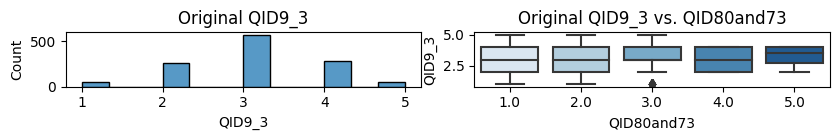



['How often do you brew your own beer?', {1: 'Several times a year', 2: 'A few times a year', 3: 'About once a year', 4: 'Just tried it once or twice', 5: 'Never'}]


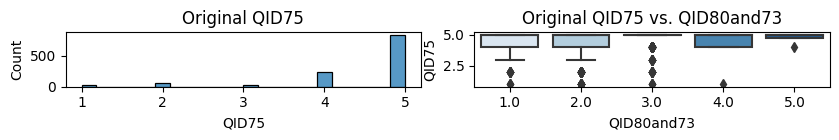



['How frequently you engage in: helping the environment', {1: 'Very frequently', 2: 'Frequently', 3: 'Occasionally', 4: 'Rarely', 5: 'Never'}]


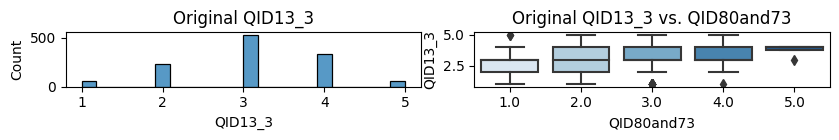



['How concerned are you about environmental issues?', {1: 'Not at all concerned', 5: 'Very concerned'}]


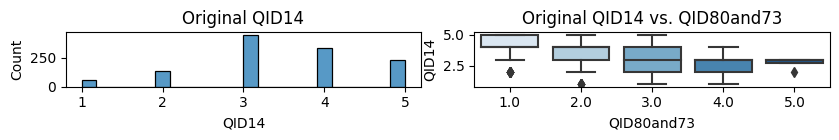



['I purchase environmentally-friendly or “green"products when the option is available (1 always - 5 rarely)', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]


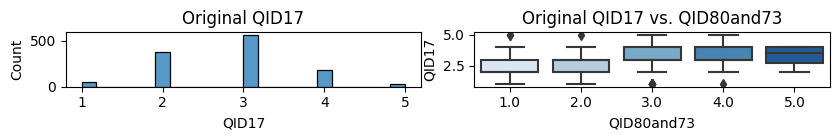



['How frequently you: purchase organically grown food?', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]


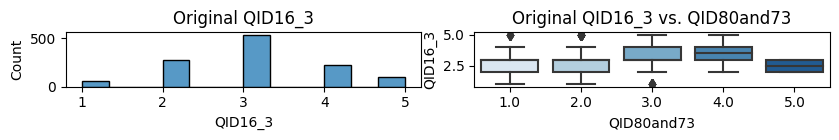



['When it comes to politics do you usually think of yourself as...', {1: 'Extremely liberal', 2: 'Liberal', 3: 'Slightly liberal', 4: 'Moderate or middle of the road', 5: 'Slightly conservative', 6: 'Conservative', 7: 'Extremely conservative', 8: "I haven't thought much about this"}]


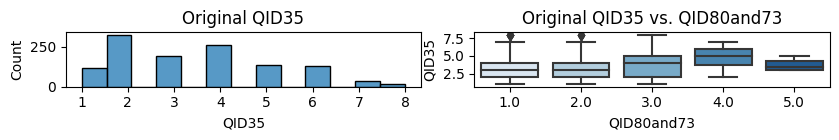



['Considering all sources which of the following best describes your total household income before taxes in 2015?', {1: 'Under $15k', 2: '$15k-$24,999', 3: '$25k-$34,999', 4: '$35k-$49,999', 5: '$50k-$74,999', 6: '$75k-$99,999', 7: '$100k-$149,999', 8: '$150k-$199,999', 9: '$200k-$249,999', 10: 'Above $250k'}]


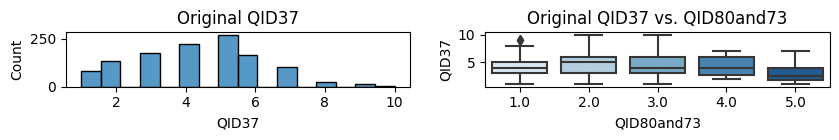

In [ ]:
#here we're having a look at each variable in relation to QID80and73, the sustainability likelihood

plt.rcParams["figure.figsize"] = [8.5, 1.5]
plt.rcParams["figure.autolayout"] = True
predictors_1eda = ['QID9_3','QID75','QID13_3','QID14','QID17','QID16_3','QID35','QID37']
for d in predictors_1eda:
#for d in df.columns[4:]:
    if d!="QID80and73" and d!='state':
      if d in question_cols_mapping.keys():
        print(question_cols_mapping[d])
      f, axes = plt.subplots(1, 2)
      little_train = df[[d,"QID80and73"]].copy()
      sns.histplot(x = little_train[d], data=little_train,ax=axes[0]).set(title="Original "+d)
      sns.boxplot(y = little_train[d], x = "QID80and73", palette='Blues',data=little_train,ax=axes[1]).set(title="Original "+d+" vs. QID80and73")
      plt.show()
      print("=====================================================================\n\n")

#these are just selected superficially by looking at the boxplots & determining which variables could be useful for interpretation as well as
#have a distinction between options 2 & 3 for QID80and73
predictors_1eda = ['QID9_3','QID75','QID13_3','QID14','QID17','QID16_3','QID35','QID37']

['How frequently you purchase domestic craft beer', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]


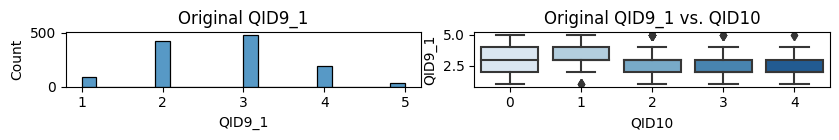



['How frequently you purchase domestic mass-produced beer', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]


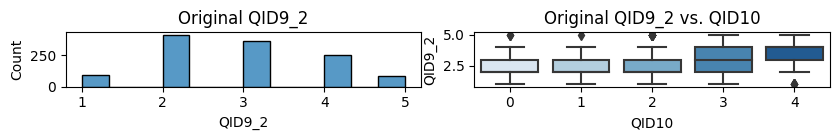



['How frequently you purchase imported beer', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]


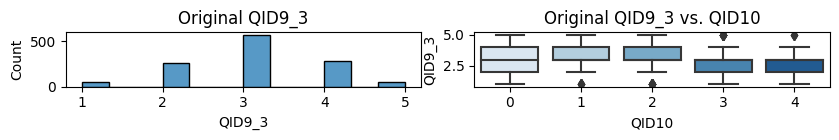



['How frequently you: purchase organically grown food?', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]


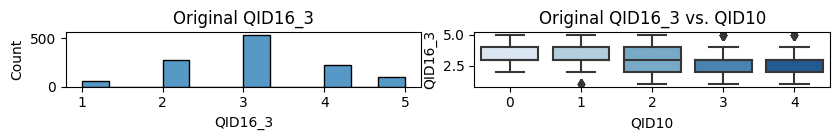



['How many people, including children, live in your household?']


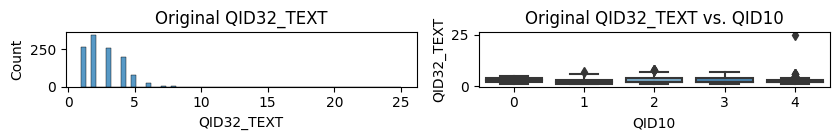



['When it comes to politics do you usually think of yourself as...', {1: 'Extremely liberal', 2: 'Liberal', 3: 'Slightly liberal', 4: 'Moderate or middle of the road', 5: 'Slightly conservative', 6: 'Conservative', 7: 'Extremely conservative', 8: "I haven't thought much about this"}]


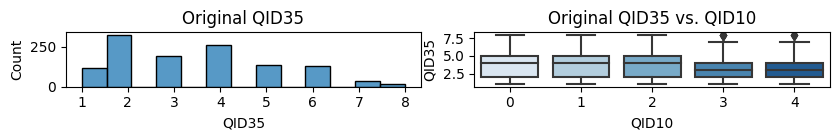



['Considering all sources which of the following best describes your total household income before taxes in 2015?', {1: 'Under $15k', 2: '$15k-$24,999', 3: '$25k-$34,999', 4: '$35k-$49,999', 5: '$50k-$74,999', 6: '$75k-$99,999', 7: '$100k-$149,999', 8: '$150k-$199,999', 9: '$200k-$249,999', 10: 'Above $250k'}]


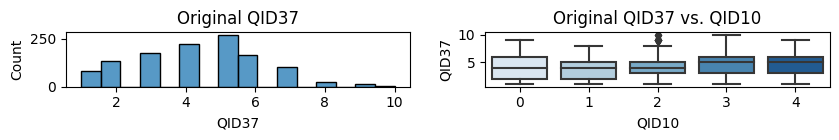

In [ ]:
#here we're having a look at each variable in relation to QID10, the spend on a 6pack
plt.rcParams["figure.figsize"] = [8.5, 1.5]
plt.rcParams["figure.autolayout"] = True

predictors_2eda = ['QID9_1','QID9_2','QID9_3','QID16_3','QID32_TEXT','QID35','QID37']
for d in predictors_2eda:
#for d in df.columns[4:]:
    if d!="QID10" and d!='state':
      if d in question_cols_mapping.keys():
        print(question_cols_mapping[d])
      f, axes = plt.subplots(1, 2)
      little_train = df[[d,"QID10"]].copy()
      sns.histplot(x = little_train[d], data=little_train,ax=axes[0]).set(title="Original "+d)
      sns.boxplot(y = little_train[d], x = "QID10", palette='Blues',data=little_train,ax=axes[1]).set(title="Original "+d+" vs. QID10")
      plt.show()
      print("=====================================================================\n\n")

#these are just selected superficially by looking at the boxplots & determining which variables could be useful for interpretation as well as
#have a distinction between options 2 & 3 for QID10
predictors_2eda = ['QID9_1','QID9_2','QID9_3','QID16_3','QID32_TEXT','QID35','QID37']

##### 3.c. **Variable selection, dataset creation for use in biogeme**

In [ ]:
#select our predictors, list the alternatives questions
#the 2 blocks in the dataset are the same question posed about a hypothetical beer vs. the beer they currently buy
predictors_1interesting = ['age','QID10','QID47','QID13_2','QID35','QID36','QID37','QID38','QID81', 'QID13_13', 'QID14', 'QID17', 'QID16_1', 'QID16_2', 'QID16_3',
                  'QID16_4', 'QID16_5', 'QID16_6', 'QID16_7']
predictors_2interesting = ['age','QID47','QID13_2','QID35','QID36','QID37','QID38','QID81', 'QID13_13', 'QID14', 'QID17', 'QID16_1', 'QID16_2', 'QID16_3',
                  'QID16_4', 'QID16_5', 'QID16_6', 'QID16_7']
alternatives_1 = 'QID80and73'
alternatives_2 = 'QID10'

predictors_1 = list(set(predictors_1interesting+predictors_1eda))#set then list again makes it a unique list
predictors_2 = list(set(predictors_2interesting+predictors_2eda))

#listing our questions with their possible answers
print("Research Topic 2 possible predictors:")
for q in predictors_1:
  print(q)
  if(len(question_cols_mapping[q]))==2:
    print(question_cols_mapping[q][0])
    print(question_cols_mapping[q][1])
  else:
    print(question_cols_mapping[q])
  print("__________________________________________\n")

print("Research Topic 2 possible predictors:")
for q in predictors_2:
  print(q)
  if(len(question_cols_mapping[q]))==2:
    print(question_cols_mapping[q][0])
    print(question_cols_mapping[q][1])
  else:
    print(question_cols_mapping[q])
  print("__________________________________________\n")

#creating our select clean datasets
df_1 = df[predictors_1+[alternatives_1]].copy()
df_2 = df[predictors_2+[alternatives_2]].copy()

# Change the knowledge question to now 1 being the least and 5 being the most
mapping = {
    5: 1,
    4: 2,
    3: 3,
    2: 4,
    1: 5
}
# Apply the mapping to the QID47 column to make more intuitive
#ex. in 9_3, it makes more sense that 5 is higher frequency of purchasing imported beer
# and 1 is a lower frequency.
df_1['QID47_F'] = df_1['QID47'].map(mapping)
df_1['QID9_3_F'] = df_1['QID9_3'].map(mapping)
df_1['QID17_F'] = df_1['QID17'].map(mapping)
df_1['QID13_2_F'] = df_1['QID13_2'].map(mapping)
df_1['QID13_3_F'] = df_1['QID13_3'].map(mapping)
df_1['QID16_3_F'] = df_1['QID16_3'].map(mapping)
df_1['QID75_F'] = df_1['QID75'].map(mapping)


df_2['QID9_1_F'] = df_2['QID9_1'].map(mapping)
df_2['QID9_2_F'] = df_2['QID9_2'].map(mapping)
df_2['QID9_3_F'] = df_2['QID9_3'].map(mapping)
df_2['QID16_3_F'] = df_2['QID16_3'].map(mapping)
df_2['QID13_2_F'] = df_2['QID13_2'].map(mapping)
df_2['QID47_F'] = df_2['QID47'].map(mapping)



Research Topic 2 possible predictors:
QID38
How would you describe your residence?
{1: 'Rural', 2: 'Urban', 3: 'Suburban', 4: 'Other'}
__________________________________________

QID16_2
How frequently you: use your own bad instead of plastic or paper provided by a store
{1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}
__________________________________________

QID13_13
How frequently you engage in: volunteering or donating to charity
{1: 'Very frequently', 2: 'Frequently', 3: 'Occasionally', 4: 'Rarely', 5: 'Never'}
__________________________________________

QID17
I purchase environmentally-friendly or “green"products when the option is available (1 always - 5 rarely)
{1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}
__________________________________________

QID35
When it comes to politics do you usually think of yourself as...
{1: 'Extremely liberal', 2: 'Liberal', 3: 'Slightly liberal', 4: 'Moderate or middle of the road', 5: 'Slightly cons

In [ ]:
#having another look at at the alternatives and deleting any nan rows
#having a look at the NaN values
display(df_1.isna().sum())
df_1 = df_1.dropna()
print("\n=======\n")

print()
#having a look at the NaN values
display(df_2.isna().sum())
df_2 = df_2.dropna()

print("\n=======\n")
display(df_1[["QID80and73"]].value_counts())
print()
display(df_2[["QID10"]].value_counts())
#benchmark accuracy to beat for df_1 (QID80and73) is 43% (guessing 2 every time)
#benchmark accuracy to beat for df_2 (QID10) is 36% (guessing 3 every time)

QID38         43
QID16_2        0
QID13_13       2
QID17          1
QID35          0
age            0
QID16_3        2
QID16_5        2
QID13_3        2
QID13_2        3
QID16_1        4
QID9_3         0
QID75          0
QID37          2
QID16_7        2
QID81          1
QID16_6        0
QID47          0
QID36          0
QID14          0
QID16_4        2
QID10          0
QID80and73     0
QID47_F        0
QID9_3_F       0
QID17_F        1
QID13_2_F      3
QID13_3_F      2
QID16_3_F      2
QID75_F        0
dtype: int64

QID38         43
QID16_2        0
QID13_13       2
QID17          1
QID35          0
age            0
QID16_3        2
QID16_5        2
QID13_2        3
QID9_2         0
QID16_1        4
QID9_3         0
QID9_1         0
QID37          2
QID16_7        2
QID32_TEXT    29
QID81          1
QID16_6        0
QID47          0
QID36          0
QID14          0
QID16_4        2
QID10          0
QID9_1_F       0
QID9_2_F       0
QID9_3_F       0
QID16_3_F      2
QID13_2_F      3
QID47_F        0
dtype: int64

QID80and73
2.0           491
3.0           412
1.0           219
4.0            16
5.0             4
dtype: int64

QID10
3        399
2        390
4        186
1         86
0         58
dtype: int64

#### 4. **Research Topic 1: Likelihood to purchase sustainable beer**
In this section we build the following models:
- Multinomial model using a variable set that was interesting
- Basic & complex ordinal models using a variable set that was interesting
- Basic & complex ordinal models using a variable set that was selected from the quick EDA

Our aim is to build a model that is superior to the benchmark of guessing the majority response variable for each respondent, while investigating the impact of interesting variables as well as EDA selected variables on the likelihood.
In finding this, we are enabled to test what-if scenarios relevant to business contexts.

The benchmark model accuracy of this section is ~43%, obtained by guessing the majority class (2) for each respondent.

In [ ]:
print(round(df_1['QID80and73'].value_counts().loc[2]/df_1['QID80and73'].value_counts().sum(),4))
print(question_cols_mapping['QID80'])
print(question_cols_mapping['QID73'])

0.4299
['WTP1. If a beer was brewed sustainably, would you be more or less likely to buy it over similar beers, assuming no change in price?', {1: 'Much more likely', 2: 'Somewhat more likely', 3: 'Neither more nor less likely', 4: 'Somewhat less likely', 5: 'Much less likely'}]
['WTP2. If a beer was brewed sustainably, would you be more or less likely to buy it over similar beers, assuming no change in price?', {1: 'Much more likely', 2: 'Somewhat more likely', 3: 'Neither more nor less likely', 4: 'Somewhat less likely', 5: 'Much less likely'}]


In [ ]:
qbus_update_globals_bgm(df_1)

##### 4.a. **Simple multinomial model using a variable set that was interesting**

Here is a multinomial logit using the features of knowledge, exercise, education, and income.

We have five categories and four variables, which are socioeconomic characteristics, thus, we have one per category. This means we will have 5 x 4 = 20 coefficients.

In [ ]:
ASC_MuchLess = exp.Beta ( 'ASC_MuchLess' ,0, None , None ,0)
ASC_SomewhatLess = exp.Beta ( 'ASC_SomewhatLess' ,0, None , None ,0)
ASC_Indifferent = exp.Beta ( 'ASC_Indifferent' ,0, None , None ,1)
ASC_SomewhatMore = exp.Beta ( 'ASC_SomewhatMore' ,0, None , None ,0)
ASC_MuchMore = exp.Beta ( 'ASC_MuchMore' ,0, None , None ,0)

In [ ]:
B_Knowledge_MuchLess = exp.Beta ( 'B_Knowledge_MuchLess' ,0, None , None ,0)
B_Exercise_MuchLess = exp.Beta ( 'B_Exercise_MuchLess' ,0, None , None ,0)
B_Education_MuchLess = exp.Beta ( 'B_Education_MuchLess' ,0, None , None ,0)
B_Income_MuchLess = exp.Beta ( 'B_Income_MuchLess' ,0, None , None ,0)

V_MuchLess = B_Knowledge_MuchLess*QID47_F + B_Exercise_MuchLess*QID13_2_F + B_Education_MuchLess*QID36 + B_Income_MuchLess*QID37 + ASC_MuchLess

In [ ]:
B_Knowledge_SomewhatLess = exp.Beta ( 'B_Knowledge_SomewhatLess' ,0, None , None ,0)
B_Exercise_SomewhatLess = exp.Beta ( 'B_Exercise_SomewhatLess' ,0, None , None ,0)
B_Education_SomewhatLess = exp.Beta ( 'B_Education_SomewhatLess' ,0, None , None ,0)
B_Income_SomewhatLess = exp.Beta ( 'B_Income_SomewhatLess' ,0, None , None ,0)

V_SomewhatLess = B_Knowledge_SomewhatLess*QID47_F + B_Exercise_SomewhatLess*QID13_2_F + B_Education_SomewhatLess*QID36 + B_Income_SomewhatLess*QID37 + ASC_SomewhatLess

In [ ]:
B_Knowledge_Indifferent = exp.Beta ( 'B_Knowledge_Indifferent' ,0, None , None ,0)
B_Exercise_Indifferent = exp.Beta ( 'B_Exercise_Indifferent' ,0, None , None ,0)
B_Education_Indifferent = exp.Beta ( 'B_Education_Indifferent' ,0, None , None ,0)
B_Income_Indifferent = exp.Beta ( 'B_Income_Indifferent' ,0, None , None ,0)

V_Indifferent = B_Knowledge_Indifferent*QID47_F + B_Exercise_Indifferent*QID13_2_F + B_Education_Indifferent*QID36 + B_Income_Indifferent*QID37 + ASC_Indifferent

In [ ]:
B_Knowledge_SomewhatMore = exp.Beta ( 'B_Knowledge_SomewhatMore' ,0, None , None ,0)
B_Exercise_SomewhatMore = exp.Beta ( 'B_Exercise_SomewhatMore' ,0, None , None ,0)
B_Education_SomewhatMore = exp.Beta ( 'B_Education_SomewhatMore' ,0, None , None ,0)
B_Income_SomewhatMore = exp.Beta ( 'B_Income_SomewhatMore' ,0, None , None ,0)

V_SomewhatMore = B_Knowledge_SomewhatMore*QID47_F + B_Exercise_SomewhatMore*QID13_2_F + B_Education_SomewhatMore*QID36 + B_Income_SomewhatMore*QID37 + ASC_SomewhatMore

In [ ]:
B_Knowledge_MuchMore = exp.Beta ( 'B_Knowledge_MuchMore' ,0, None , None ,0)
B_Exercise_MuchMore = exp.Beta ( 'B_Exercise_MuchMore' ,0, None , None ,0)
B_Education_MuchMore = exp.Beta ( 'B_Education_MuchMore' ,0, None , None ,0)
B_Income_MuchMore = exp.Beta ( 'B_Income_MuchMore' ,0, None , None ,0)

V_MuchMore = B_Knowledge_MuchMore*QID47_F + B_Exercise_MuchMore*QID13_2_F + B_Education_MuchMore*QID36 + B_Income_MuchMore*QID37 + ASC_MuchMore

In [ ]:
#define model

V_base = {1: V_MuchLess,
     2: V_SomewhatLess,
     3: V_Indifferent,
     4: V_SomewhatMore,
     5: V_MuchMore}

av = {1:1, 2:1, 3:1, 4:1, 5:1}

logprob = models.loglogit (V_base , av , QID80and73 )
df_1_db = db.Database('df_1_db', df_1)

bgm_model_mnl = bio.BIOGEME ( df_1_db, logprob )
results_mnl = bgm_model_mnl.estimate()

In [ ]:
results_mnl.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_MuchLess,-1.141469,0.486708,-2.345286,0.019013
ASC_MuchMore,-8.319866,2.357883,-3.528532,0.000418
ASC_SomewhatLess,-1.181570,0.361788,-3.265920,0.001091
ASC_SomewhatMore,-4.529215,1.789627,-2.530814,0.011380
B_Education_Indifferent,-0.060445,0.070807,-0.853658,0.393294
B_Education_MuchLess,-0.107567,0.077305,-1.391459,0.164086
B_Education_MuchMore,0.296451,0.184971,1.602693,0.109002
B_Education_SomewhatLess,-0.054918,0.069663,-0.788334,0.430502
B_Education_SomewhatMore,-0.073522,0.174144,-0.422189,0.672887
B_Exercise_Indifferent,-0.274048,0.101982,-2.687228,0.007205


###### **Interpretation**

Here we have a coefficient of each variable for each choice the individual makes. The main take aways are:

ASC Analysis:
* Remember that the ASC values are relative to the "Indifferent" option in this report. Interestingly, they are all negative, meaning that the "Indifferent" option has the highest utility, followed by "SomewhatLess", "MuchLess","SomewhatMore", and finally "MuchMore." Suppose we ignore the "Indifferent" choice. In that case, the utilities are in almost perfectly in order: desiring the beer much less has the highest utility, and desiring the beer a lot more has the lowest utility. This is interesting as there is no change in price between options; the only difference is the sustainability of the beer. This makes us think, are they worried about taste with sustainability or some other change? Or do they simply not like sustainably made goods?

Coefficients:
* It appears being more educated derives the most utility for the choice "MuchMore", having a coefficient of 0.296817, implying that the more education you have, you gain more utility choosing "MuchMore" than the other options. Interestingly, the order of coefficients for education is almost perfect, from "MuchLess" to "MuchMore." This further supports the first statement that more education will give an individual greater utility in choosing a sustainable beer. This could be because education teaches people how non-sustainable goods negatively influence the environment and how sustainable goods are better for you health-wise.
* There is no clear order in coefficients for exercise, but we can clearly see that the "more" choices are positive and the "less" choices are negative. Revealing that the more the individual exercises, the more likely they are to prefer sustainable beer which makes sense. As if an individual exercises, they are more likely to care about their overall health. As sustainable ingredients are usually healthier than conventional counterparts, it would seem logical that the more an individual does sport, the more likely they would want a sustainable beer for the same price, so let us see.
* More income appears to derive more utility for every choice except "MuchMore". It is important to remember only 4 indiviudals chose "MuchMore" so there is a lot of error in terms of the coefficients for the "MuchMore" choice as the sample size is very small.
* In terms of having more knowledge of beer, there is no clear order in terms of coefficients. However, even though we only had 4 individuals choosing "MuchMore", the coefficient is quite high compared to the other choices.

##### 4.b. **Base Ordinal Model**

We will build a base ordinal model using the same features as the multinomial model above to find out if the ordinal model is statistically more accurate.

In [ ]:
ASC_ord = exp.Beta('ASC_ord', 0, None, None, 0)
B_Knowledge = exp.Beta ( 'B_Knowledge' ,0, None , None ,0)
B_Exercise = exp.Beta ( 'B_Exercise' ,0, None , None ,0)
B_Education = exp.Beta ( 'B_Education' ,0, None , None ,0)
B_Income = exp.Beta ( 'B_Income' ,0, None , None ,0)
B_Politics = exp.Beta ( 'B_Politics' ,0, None , None ,0)

qbus_update_globals_bgm(df_1)

We only need to build one utility function as there are no features per choice.

In [ ]:
V_ord = ASC_ord +B_Knowledge*QID47_F + B_Exercise*QID13_2_F + B_Education*QID36 + B_Income*QID37 + B_Politics*QID35

In [ ]:
base_ord_model, base_ord_results = qbus_estimate_ordered_bgm(V_ord, [1,2,3,4,5], df_1, 'QID80and73', )

In [ ]:
base_ord_results.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_ord,0.097206,0.189721,0.512360,6.083994e-01
B_Education,0.069574,0.045146,1.541087,1.232955e-01
B_Exercise,-0.075710,0.059036,-1.282440,1.996882e-01
B_Income,-0.016862,0.033278,-0.506697,6.123674e-01
B_Knowledge,-0.152536,0.064760,-2.355410,1.850228e-02
B_Politics,0.249299,0.037499,6.648200,2.967004e-11
delta_2,2.017713,0.081696,24.697882,0.000000e+00
delta_3,3.621436,0.225034,16.092813,0.000000e+00
delta_4,1.627033,0.449639,3.618530,2.962814e-04
tau1,-1.097206,0.189721,-5.783248,7.327208e-09


###### **Interpretation**

The important distinction between the ordered logit and the multinomial is the inclusion of cut-off points. These are values that split the utility into different alternatives. In terms of the table above, these are called tau's, where tau1 indicates the first cut-off point, however, the rest must be calculated to find the precise point. Where: tau2 = tau1 + delta2, tau3 = tau2 + delta3 (or alternatively, tau3 = tau1 + delta2 + delta3).

However, for this to be feasible, there must be a logical order to the choice options, which is the case in this dataset. As, this is the current definition of QID80and73 {1: 'Much more likely', 2: 'Somewhat more likely', 3: 'Neither more nor less likely', 4: 'Somewhat less likely', 5: 'Much less likely'} which can be interpreted as most to least likely and in this case, to desire sustainable beer with no change in price. Thus, there is order.

Coefficients:

* The more education someone has, the more utility they gain by choosing a choice that indicates they are less likely to prefer a sustainable beer, which goes against the multinomial logit above. It is important to note in both models the coefficients for education did not have statistically significant evidence to be different from zero at a 95% confidence level.
* Exercise is negative which is consistent with the multinomial logit, but again, not statistically significant as explained above.
* The more income someone has, they gain less utility by choosing options that indicate they are less likely to prefer a sustainable beer, but again, not statistically significant as explained above.
* The more knowledge someone has, they gain less utility by choosing options that indicate they are less likely to prefer a sustainable beer, this coefficient of -0.155376 does have statistically significant evidence to reject the null hypothesis that the coefficient is equal to zero at a 95% confidence level.

##### 4.c. **Residential Impact**

Let us see if the more urban an individual lives, if the likelihood of them preferring sustainable beers increases. This could be through societal pressures which are different depending where they live, as the European Environment Agency (2023) found people in Urban areas are exposed to more health and environmental issues.

We need to re-map the current entries for "QID38" as currently the mapping is {1: 'Rural', 2: 'Urban', 3: 'Suburban', 4: 'Other'}.
However, our research question in words is, "Does the more urban an individual live, the more they desire sustainable beer?". As there are only 4 entries in "Other", we will rank this below Rural, so we must change our mapping to {1: 'Other', 2: 'Rural', 3: 'Suburban', 4: 'Urban'}. This can be seen below:



In [ ]:
df_RI = df_1.copy()

# Define a mapping dictionary
mapping = {
    4: 1,
    1: 2,
    3: 3,
    2: 4
}
# Apply the mapping to the QID38 column
df_RI['QID38'] = df_RI['QID38'].map(mapping)

In [ ]:
B_Knowledge = exp.Beta ( 'B_Knowledge' ,0, None , None ,0)
B_Exercise = exp.Beta ( 'B_Exercise' ,0, None , None ,0)
B_Education = exp.Beta ( 'B_Education' ,0, None , None ,0)
B_Income = exp.Beta ( 'B_Income' ,0, None , None ,0)
B_Politics = exp.Beta ( 'B_Politics' ,0, None , None ,0)
B_Residence = exp.Beta ( 'B_Residence' ,0, None , None ,0)



qbus_update_globals_bgm(df_RI)

Our utility function will be the same as the base but we will now also add the Residential question ("QID38").

In [ ]:
V_ord_RI = ASC_ord + B_Knowledge*QID47 + B_Exercise*QID13_2_F + B_Education*QID36 + B_Income*QID37 + B_Politics*QID35 + B_Residence*QID38

Now, obtaining the model and results of the residential included model.


In [ ]:
RI_ord_model, RI_ord_results = qbus_estimate_ordered_bgm(V_ord_RI, [1,2,3,4,5], df_RI, 'QID80and73', )

In [ ]:
RI_ord_results.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_ord,-0.498105,0.209417,-2.378529,1.738188e-02
B_Education,0.065049,0.045316,1.435440,1.511618e-01
B_Exercise,-0.079188,0.058991,-1.342363,1.794784e-01
B_Income,-0.016210,0.033232,-0.487777,6.257075e-01
B_Knowledge,0.152839,0.064657,2.363851,1.808608e-02
B_Politics,0.254399,0.038046,6.686603,2.284106e-11
B_Residence,0.091464,0.078882,1.159503,2.462513e-01
delta_2,2.019321,0.081838,24.674688,0.000000e+00
delta_3,3.623338,0.224889,16.111686,0.000000e+00
delta_4,1.627440,0.449619,3.619599,2.950599e-04


###### **Interpretation**

We can see that the beta coefficient for Residence is 0.086382 which is very small. We can see the p-value is greater than 0.05, so we are not 95% confident that the coefficient is different from zero. That means there is no statistically significant evidence to reject the null hypothesis that residence has no influence on whether an individual prefers sustainable beer.

Let us also conduct a statistical test on whether the models are statistically different. We can do this as the models are nested (the one with residence includes all the variables of the base model). We will use the likelihood ratio test, where the null hyptohesis is that the new complex model is not significantly better than the reference model. By the way the models are constructed, the more complex model includes all the variables as the first so it will always have the same or better likelihood than the reference. The test statistics is $2(\text{Loglikelihood}_\text{complex model} - \text{Loglikelihood}_\text{reference model})$ and it is distributed as a Chi-squared distribution with 1 degrees of freedom equal as that is the difference in the number of parameters.

In [ ]:
qbus_likeli_ratio_test_bgm(RI_ord_results, base_ord_results, 0.05)

LRTuple(message='H0 cannot be rejected at level 5.0%', statistic=1.2777462641647617, threshold=3.841458820694124)

It makes sense that the null cannot be rejected as the coefficient for residence was not statistically significant.

##### 4.d. **Does age have influence on whether an individual prefers sustainable beer?**

Let us see if the more urban an individual lives, if the likelihood of them preferring sustainable beers increases. This could be through societal pressures which are different depending where they live, as the European Environment Agency (2023) found people in Urban areas are exposed to more health and environmental issues.

We need to re-map the current entries for "QID38" as currently the mapping is {1: 'Rural', 2: 'Urban', 3: 'Suburban', 4: 'Other'}.
However, our research question in words is, "Does the more urban an individual live, the more they desire sustainable beer?". As there are only 4 entries in "Other", we will rank this below Rural, so we must change our mapping to {1: 'Other', 2: 'Rural', 3: 'Suburban', 4: 'Urban'}. This can be seen below:

In [ ]:
df_age = df_1.copy()

B_Knowledge = exp.Beta ( 'B_Knowledge' ,0, None , None ,0)
B_Exercise = exp.Beta ( 'B_Exercise' ,0, None , None ,0)
B_Education = exp.Beta ( 'B_Education' ,0, None , None ,0)
B_Income = exp.Beta ( 'B_Income' ,0, None , None ,0)
B_Politics = exp.Beta ( 'B_Politics' ,0, None , None ,0)
B_Age = exp.Beta ( 'B_Age' ,0, None , None ,0)



qbus_update_globals_bgm(df_age)

Our utility function will be the same as the base, but we will now add the Age question ("age").

In [ ]:
V_ord_age = ASC_ord + B_Knowledge*QID47 + B_Exercise*QID13_2_F + B_Education*QID36 + B_Income*QID37 + B_Politics*QID35 + B_Age*age

Now, obtaining the model and results of the age included model.


In [ ]:
Age_ord_model, Age_ord_results = qbus_estimate_ordered_bgm(V_ord_age, [1,2,3,4,5], df_age, 'QID80and73', )

In [ ]:
Age_ord_results.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_ord,-0.337109,0.203716,-1.654801,9.796491e-02
B_Age,-0.001340,0.006060,-0.221123,8.249964e-01
B_Education,0.069177,0.045405,1.523548,1.276217e-01
B_Exercise,-0.077136,0.059299,-1.300782,1.933332e-01
B_Income,-0.016297,0.033548,-0.485773,6.271284e-01
B_Knowledge,0.152759,0.064803,2.357271,1.840981e-02
B_Politics,0.250036,0.037851,6.605770,3.954570e-11
delta_2,2.017892,0.081705,24.697360,0.000000e+00
delta_3,3.621219,0.225030,16.092153,0.000000e+00
delta_4,1.627002,0.449637,3.618481,2.963367e-04


###### **Interpretation**


It appears that age is not statistically significant. This may be because the age variable is quite substantial compared to the other variables; let's try classifying "age" into smaller numbers, say grouping every six years as there may not be much difference mentally from one year to the next when caring about sustainability.

Below creates a new variable that does what was described above.

In [ ]:
# Calculate Q1
df_age['Age2'] = df_age['age'].apply(lambda x: ((x - 21) // 7) + 1 if 21 <= x <= 100 else None)

qbus_update_globals_bgm(df_age)

Now lets obtain the new results.

In [ ]:
V_ord_age2 = ASC_ord + B_Knowledge*QID47 + B_Exercise*QID13_2 + B_Education*QID36 + B_Income*QID37 + B_Politics*QID35 + B_Age*Age2
Age_ord_model2, Age_ord_results2 = qbus_estimate_ordered_bgm(V_ord_age2, [1,2,3,4,5], df_age, 'QID80and73', )
Age_ord_results2.getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_ord,-0.569758,0.170962,-3.332663,8.601914e-04
B_Age,-0.021011,0.041398,-0.507536,6.117786e-01
B_Education,0.068500,0.045410,1.508490,1.314292e-01
B_Exercise,0.079050,0.059333,1.332318,1.827556e-01
B_Income,-0.015688,0.033530,-0.467867,6.398798e-01
B_Knowledge,0.152904,0.064778,2.360417,1.825439e-02
B_Politics,0.250965,0.037866,6.627701,3.409539e-11
delta_2,2.018315,0.081730,24.694843,0.000000e+00
delta_3,3.621093,0.225050,16.090151,0.000000e+00
delta_4,1.626960,0.449632,3.618423,2.964031e-04


Age still does not have a statistically significant coefficient.

##### 4.e. **How does Political Views Influence Sustainable Beer Choices?**

From the result outputs of the previous questions, it appears that politics is the only coefficient to be statistically significant. So, let's look at the proportions of each choice of people from the same political group and how they compare to others.

In [ ]:
qid35_mapping = {
    1: 'Extremely liberal',
    2: 'Liberal',
    3: 'Slightly liberal',
    4: 'Moderate or middle of the road',
    5: 'Slightly conservative',
    6: 'Conservative',
    7: 'Extremely conservative',
    8: "I haven't thought much about this"
}

for i in range(1, 9):
    filtered = df_1[df_1['QID35'] == i]
    proportions = pd.crosstab(filtered['QID80and73'], 'Count', normalize='all')

    print(f"For {qid35_mapping[i]}:")
    print(proportions)
    print("\n")

For Extremely liberal:
col_0          Count
QID80and73          
1.0         0.348624
2.0         0.376147
3.0         0.275229


For Liberal:
col_0          Count
QID80and73          
1.0         0.222951
2.0         0.508197
3.0         0.265574
4.0         0.003279


For Slightly liberal:
col_0          Count
QID80and73          
1.0         0.155914
2.0         0.543011
3.0         0.274194
4.0         0.016129
5.0         0.010753


For Moderate or middle of the road:
col_0          Count
QID80and73          
1.0         0.168067
2.0         0.382353
3.0         0.436975
4.0         0.008403
5.0         0.004202


For Slightly conservative:
col_0          Count
QID80and73          
1.0         0.167939
2.0         0.389313
3.0         0.404580
4.0         0.030534
5.0         0.007634


For Conservative:
col_0          Count
QID80and73          
1.0         0.105691
2.0         0.317073
3.0         0.536585
4.0         0.040650


For Extremely conservative:
col_0          Count
QI

###### **Interpretation**

It appears that being extremely Liberal means that you are either indifferent or more likely to buy a sustainable beer, but never less likely, which is interesting. The liberal group is very similar, but a small proportion is less likely to choose the beer if it is now sustainable. This is starting to reveal a trend that being more liberal means you care more about sustainability. The moderate or the middle political group is spread across all choices but with higher proportions in the preferred sustainable beer choices. The rest of the political groups are consistent with the previous statement that the more liberal groups prefer more sustainable beer with no change in price, and the more conservative groups are less likely to choose a beer if it is now sustainable with no change in price.

##### 4.f. **Is There a Carry-Over Effect When Caring About Sustainability?**
If an individual cares about other sustainable actions, it seems logical they would prefer sustainable beer as they believe in the cause. Multiple questions in the survey ask about the individuals current sustainability beliefs, so lets add those up as one variable and squash it (normalise) and see if this variable is statistically significant. This variable indicates the overall level of how much the individual cares about sustainability.

These are the chosen questions:

'QID13_13':['How frequently you engage in: volunteering or donating to charity',
                                    {1:'Very frequently',2:'Frequently',3:'Occasionally',
                                     4:'Rarely',5:'Never'}],
                         
'QID14':['How concerned are you about environmental issues?',
                                  {1:'Not at all concerned',5:'Very concerned'}],

'QID17':['I purchase environmentally-friendly or “green"products when the option is available (1 always - 5 rarely)',
                                  {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],

'QID16_1':['How frequently you: compost waste',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         
'QID16_2':['How frequently you: use your own bad instead of plastic or paper provided by a store',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         
'QID16_3':['How frequently you: purchase organically grown food?',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         
'QID16_4':['How frequently you: purchase recycled paper products?',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         
'QID16_5':['How frequently you: turn off the water faucet while brushing your teeth?',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         
'QID16_6':['How frequently you: keep heating low to save energy?',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}],
                         
'QID16_7':['How frequently you: recycle?',
                                    {1:'Always',2:'Usually',3:'Sometimes',4:'Rarely',5:'Never'}]

In [ ]:
df_sustainable = df_1.copy()

columns_to_sum = ['QID13_13', 'QID14', 'QID17', 'QID16_1', 'QID16_2', 'QID16_3',
                  'QID16_4', 'QID16_5', 'QID16_6', 'QID16_7']

df_sustainable['QID_Sustainable'] = df_sustainable[columns_to_sum].sum(axis=1)

#Normalise
df_sustainable['QID_Sustainable'] = np.sqrt(df_sustainable['QID_Sustainable'])


In [ ]:
B_Knowledge = exp.Beta ( 'B_Knowledge' ,0, None , None ,0)
B_Exercise = exp.Beta ( 'B_Exercise' ,0, None , None ,0)
B_Education = exp.Beta ( 'B_Education' ,0, None , None ,0)
B_Income = exp.Beta ( 'B_Income' ,0, None , None ,0)
B_Politics = exp.Beta ( 'B_Politics' ,0, None , None ,0)
B_Sustainable = exp.Beta ( 'B_Sustainable' ,0, None , None ,0)

qbus_update_globals_bgm(df_sustainable)


Our utility function will be the same as the base, but we will now add the Sustainable variable we made above ("QID_Sustainable").

In [ ]:
V_ord_sustainable = ASC_ord + B_Knowledge*QID47 + B_Exercise*QID13_2 + B_Education*QID36 + B_Income*QID37 + B_Politics*QID35 + B_Sustainable*QID_Sustainable


In [ ]:
Sustainable_ord_model, Sustainable_ord_results = qbus_estimate_ordered_bgm(V_ord_sustainable, [1,2,3,4,5], df_sustainable, 'QID80and73', )

In [ ]:
Sustainable_ord_results.getEstimatedParameters()


,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_ord,-3.242246,0.335347,-9.668326,0.000000e+00
B_Education,0.098247,0.046346,2.119883,3.401595e-02
B_Exercise,-0.025619,0.060266,-0.425107,6.707585e-01
B_Income,-0.000042,0.033999,-0.001231,9.990175e-01
B_Knowledge,0.069521,0.066354,1.047728,2.947640e-01
B_Politics,0.208070,0.037789,5.506055,3.669637e-08
B_Sustainable,1.093822,0.122328,8.941714,0.000000e+00
delta_2,2.135031,0.087375,24.435196,0.000000e+00
delta_3,3.738804,0.231957,16.118524,0.000000e+00
delta_4,1.627865,0.450299,3.615074,3.002622e-04


###### **Interpretation**


At first glance, this does not make sense as the coefficient is positive, indicating that the higher the value of the sustainable variable, the less utility the individual derives from picking a choice that indicates the individual would rather the sustainable beer. But, analysing how the variable was made makes sense of the coefficient, as a lower number actually represents a more sustainable person which can be seen in the mapping above. Thus, the more an individual practices or cares about areas of sustainability, the more utility they derive picking a choice they are more likely to prefer the sustainable beer.

The coefficient of 1.093822 has statistically significant evidence to reject the null hypothesis that it is equal to zero at the 95% confidence level.

Let us also test the statistical significance of the model outlined earlier.

In [ ]:
qbus_likeli_ratio_test_bgm(Sustainable_ord_results, base_ord_results, 0.05)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=83.80402158569132, threshold=3.841458820694124)

This model has had a statistically significant improvement in likelihood to the base ordinal logit.

##### 4.g. **Summary of Findings and Their Implications**

Most of the research questions found statistically insignificant results. However, there are a few statistically significant takeaways from section 4.

* 4E can be used by political parties to reach their audience better. It was clear that the more liberal a population is, the more that population will prefer sustainable beer and vice versa with a conservative group. These parties can use this information to understand their audiences' desires better. For example, liberals can push for more sustainable causes, which will cause a positive reaction their community.

 On the other hand, this can be used by political parties to gain new members. For example, a right-wing party may start new sustainable agendas to attract some current left-wing voters. However, this may have a trade-off of losing current members if they do not like these agendas.

* If you look at all the sections except 4F, the coefficient for knowledge is statistically different from zero at a 95% confidence level. The reason it may have been insignificant in the most recent section is that knowledgable people take part in sustainable activities, which was would be captured in the new variable, making the knowledge coefficient insignificant. In terms of insights, this still shows that if a business educates its consumers or potential customers of different types of beer regarding sustainability efforts, it will improve the utility of an individual choosing a more sustainable beer. Thus, businesses should advertise their sustainable beers and clearly communicate how they are sustainable. Governments can also use this information to conduct research papers and advertise the health benefits of sustainable beer, which will push their citizens to start purchasing more sustainable beer, as this will allow them to achieve their sustainability goals and also improve the health of their citizens.

These are interesting insights, but their use in practice requires the determination of the accuracy of the models they arise from. The next section compares basic and complex versions of models built from the two variable sets: stakeholder interest and EDA.


##### 4.h. **Comparison of basic & complex ordinal models using a variable set that was interesting**

In this section, we seek to compare two ordinals models that implement the interesting variables. As knowledge of beer and political leaning were given strong coefficients in the previous section, they were included in this model as well. In addition, the basic model includes age and income for interest. The complex models additionally included level of engagement in sport, spend on a 6-pack of beer, education, and urban-rural residential status.

In [ ]:
#listing our potential predictors
for i in predictors_1interesting:
  print(i)
  print(question_cols_mapping[i])

age
What is your age?
QID10
['When you buy beer at the store, how much do you usually spend on a 6-pack?', {1: '$3-$5.99', 2: '$6-7.99', 3: '$8-$9.99', 4: '$10-$12', 5: 'I do not buy beer in a 6-pack'}]
QID47
['How knowledgeable would you say you are about types of beer, as well as beer in general?', {1: 'Very knowledgable', 2: 'Somewhat knowledgable', 3: 'Not too knowledgable', 4: 'A little knowledgable', 5: "I haven't really thought about this topic"}]
QID13_2
['How frequently you engage in: playing sports, exercise, or recreation', {1: 'Very frequently', 2: 'Frequently', 3: 'Occasionally', 4: 'Rarely', 5: 'Never'}]
QID35
['When it comes to politics do you usually think of yourself as...', {1: 'Extremely liberal', 2: 'Liberal', 3: 'Slightly liberal', 4: 'Moderate or middle of the road', 5: 'Slightly conservative', 6: 'Conservative', 7: 'Extremely conservative', 8: "I haven't thought much about this"}]
QID36
['What is the highest level of education you have completed?', {1: 'Less than

In [ ]:
# Parameters to be estimated
B_age = exp.Beta('B_age', 0, None, None, 0)
B_knowledge = exp.Beta('B_knowledge', 0, None, None, 0)#QID47
B_politics = exp.Beta('B_politics', 0, None, None, 0)#QID35
B_income = exp.Beta('B_income', 0, None, None, 0)#QID37
#define model
V_basic = B_age*age + B_knowledge*QID47_F  + B_politics*QID35 + B_income*QID37

#build & assess
results_basic = df1_buildmodel(V_basic,df_1)

#complex model
# Parameters to be estimated
B_age = exp.Beta('B_age', 0, None, None, 0)
B_spend6pack = exp.Beta('B_spend6pack', 0, None, None, 0)#QID10
B_knowledge = exp.Beta('B_knowledge', 0, None, None, 0)#QID47
B_sporty = exp.Beta('B_sporty', 0, None, None, 0)#QID13_2
B_politics = exp.Beta('B_politics', 0, None, None, 0)#QID35
B_education = exp.Beta('B_education', 0, None, None, 0)#QID36
B_income = exp.Beta('B_income', 0, None, None, 0)#QID37
B_residence = exp.Beta('B_residence', 0, None, None, 0)#QID38

#define model
V_complex = B_age*age + B_spend6pack*QID10 + B_knowledge*QID47_F + B_sporty*QID13_2_F + B_politics*QID35 + B_education*QID36 + B_income*QID37 + B_residence*QID38

#build & assess
results_complex = df1_buildmodel(V_complex,df_1)

#likelihood ratio test
tools.likelihood_ratio_test( (results_complex.data.logLike, results_complex.data.nparam),
                                     (results_basic.data.logLike, results_basic.data.nparam), 0.05)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
B_age,-0.000910,0.005971,-0.152372,0.878894
B_income,-0.006730,0.031473,-0.213830,0.830680
B_knowledge,-0.158669,0.065092,-2.437616,0.014784
B_politics,0.243069,0.037692,6.448806,0.000000
delta2,2.012783,0.081594,24.668363,0.000000
delta3,3.616628,0.224692,16.095959,0.000000
delta4,1.626722,0.449427,3.619547,0.000295
tau1,-1.275504,0.356449,-3.578365,0.000346


(0.478984238178634,
 Predicted    2    3
 Actual             
 1.000000   165   54
 2.000000   384  107
 3.000000   249  163
 4.000000     5   11
 5.000000     3    1)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
B_age,-0.001959,0.006069,-0.322743,0.746890
B_education,0.075110,0.045390,1.654772,0.097971
B_income,0.000999,0.034505,0.028951,0.976904
B_knowledge,-0.143679,0.065377,-2.197691,0.027971
B_politics,0.242732,0.038175,6.358380,0.000000
B_residence,-0.110759,0.073921,-1.498356,0.134041
B_spend6pack,-0.077370,0.059267,-1.305463,0.191735
B_sporty,-0.080438,0.059754,-1.346156,0.178252
delta2,2.022336,0.081727,24.745128,0.000000
delta3,3.625654,0.225105,16.106478,0.000000


(0.4754816112084063,
 Predicted    2    3
 Actual             
 1.000000   170   49
 2.000000   386  105
 3.000000   255  157
 4.000000     6   10
 5.000000     3    1)

LRTuple(message='H0 cannot be rejected at level 5.0%', statistic=7.568108916008896, threshold=9.487729036781154)

**Interpretation**

The basic and complex models very similarly, at ~48%. Even with more variables, the complex model performs 0.3% worse than the basic, and is not statistically superior to the base model as shown by the ratio test. In practice, this is good news for experimental design and data collection, as recreating the basic model requires less expense and resources. However, the models only offer ~5% better guessing than the benchmark, and the confusion matrix only guesses 2 and 3 values. This performance would not offer much benefit over competitors in industry. We require superior models, which should be derived through sophisticated variable selection methods. In this demonstration though, an elementary approach was taken, where variables that look promising were determined by superficial inspection of EDA plots, and no rigour was applied to their groupings.

##### 4.i. **Comparison of basic & complex ordinal models using a variable set that was selected from the quick EDA**

In [ ]:
#listing our potential predictors
for i in predictors_1eda:
  print(i)
  print(question_cols_mapping[i])

QID9_3
['How frequently you purchase imported beer', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]
QID75
['How often do you brew your own beer?', {1: 'Several times a year', 2: 'A few times a year', 3: 'About once a year', 4: 'Just tried it once or twice', 5: 'Never'}]
QID13_3
['How frequently you engage in: helping the environment', {1: 'Very frequently', 2: 'Frequently', 3: 'Occasionally', 4: 'Rarely', 5: 'Never'}]
QID14
['How concerned are you about environmental issues?', {1: 'Not at all concerned', 5: 'Very concerned'}]
QID17
['I purchase environmentally-friendly or “green"products when the option is available (1 always - 5 rarely)', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]
QID16_3
['How frequently you: purchase organically grown food?', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]
QID35
['When it comes to politics do you usually think of yourself as...', {1: 'Extremely liberal', 2: 'Liberal', 3: 'Slight

In [ ]:
#variables selected by a superficial EDA
# Parameters to be estimated
B_importedf = exp.Beta('B_importedf', 0, None, None, 0) #QID9_3
B_brewf = exp.Beta('B_brewf', 0, None, None, 0)#QID75
B_greenpurchase = exp.Beta('B_greenpurchase', 0, None, None, 0)#QID17
B_income = exp.Beta('B_income', 0, None, None, 0)#QID37
#define model
V_eda_basic = B_importedf*QID9_3_F + B_brewf*QID75_F  + B_greenpurchase*QID17_F + B_income*QID37

#more complex version
# Parameters to be estimated
B_importedf = exp.Beta('B_importedf', 0, None, None, 0) #QID9_3
B_brewf = exp.Beta('B_brewf', 0, None, None, 0)#QID75
B_greenpurchase = exp.Beta('B_greenpurchase', 0, None, None, 0)#QID17
B_organicpurchase = exp.Beta('B_organicpurchas', 0, None, None, 0)#QID16_3
B_politics = exp.Beta('B_politics', 0, None, None, 0)#QID35
B_income = exp.Beta('B_income', 0, None, None, 0)#QID37
#define model
V_eda_complex = B_importedf*QID9_3 + B_brewf*QID75  + B_greenpurchase*QID17_F + B_organicpurchase*QID16_3_F +B_politics*QID35 +B_income*QID37


#build & assess
results_eda_basic = df1_buildmodel(V_eda_basic,df_1)
results_eda_complex = df1_buildmodel(V_eda_complex,df_1)

#likelihood ratio test
tools.likelihood_ratio_test( (results_eda_complex.data.logLike, results_eda_complex.data.nparam),
                                     (results_eda_basic.data.logLike, results_eda_basic.data.nparam), 0.05)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
B_brewf,0.053080,0.054753,0.969439,0.332326
B_greenpurchase,-1.181696,0.085213,-13.867634,0.000000
B_importedf,0.062768,0.067682,0.927391,0.353724
B_income,0.016998,0.032274,0.526684,0.598413
delta2,2.278640,0.094353,24.150108,0.000000
delta3,3.930348,0.242283,16.222138,0.000000
delta4,1.636243,0.451026,3.627824,0.000286
tau1,-5.133242,0.366984,-13.987644,0.000000


(0.5245183887915937,
 Predicted   1    2    3
 Actual                 
 1.000000   25  182   12
 2.000000   15  425   51
 3.000000    7  256  149
 4.000000    1    8    7
 5.000000    0    2    2)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
B_brewf,-0.056680,0.054961,-1.031263,0.302418
B_greenpurchase,-1.073151,0.097730,-10.980776,0.000000
B_importedf,-0.083877,0.067743,-1.238167,0.215654
B_income,-0.000519,0.032675,-0.015887,0.987325
B_organicpurchas,-0.079477,0.068571,-1.159046,0.246437
B_politics,0.144960,0.038995,3.717403,0.000201
delta2,2.305127,0.096101,23.986417,0.000000
delta3,3.961122,0.241999,16.368341,0.000000
delta4,1.640640,0.452338,3.627024,0.000287
tau1,-5.393547,0.538883,-10.008752,0.000000


(0.5376532399299475,
 Predicted   1    2    3
 Actual                 
 1.000000   25  167   27
 2.000000   15  380   96
 3.000000    7  196  209
 4.000000    1    4   11
 5.000000    0    2    2)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=17.22802102540936, threshold=5.991464547107979)

**Interpretation**

The basic and complex models differ by ~1% in accuracy and the ratio test shows a statistically significant result at the 5% level, meaning that the complex model is superior to the basic version. The complex EDA model outperforms the benchmark by ~11% and the stakeholder interest models by ~7%. The confusion matrices present a better result, where an additional value is predicted (1). In practice this means that a brewery is better able to distinguish between someone who at least claims to be much more likely to purchase sustainable beer over a non-sustainble equivalent versus someone who claims to be neutral. Still, we deem this performance to be too low to be anything but indicative rather than predictive, but such an increase in accuracy stemming from such a simplistic variable selection process shows promise that a much better performance could be achieved with more rigourous methods.

#### 5. **Research Topic 2: Spend on a 6-pack of beer**
In this section we build the following models:
- Basic & complex ordinal models using a variable set that was interesting
- Basic & complex ordinal models using a variable set that was selected from the quick EDA

In this section, the benchmark accuracy to compare to is 36%, achieved by guessing '3: \$8-\$9.99' for each respondent.

In [ ]:
print('When you buy beer at the store, how much do you usually spend on a 6-pack?',"\n", {0: 'I do not buy beer in a 6-pack',1: '$3-$5.99', 2: '$6-7.99', 3: '$8-$9.99', 4: '$10-$12'})

#benchmark accuracy
print("Benchmark accuracy:",round(404/sum(df_2['QID10'].value_counts()),4))

When you buy beer at the store, how much do you usually spend on a 6-pack? 
 {0: 'I do not buy beer in a 6-pack', 1: '$3-$5.99', 2: '$6-7.99', 3: '$8-$9.99', 4: '$10-$12'}
Benchmark accuracy: 0.361


##### 5.a. **Basic & complex ordinal models using a variable set that was interesting**

In [ ]:
qbus_update_globals_bgm(df_2)
for i in predictors_2interesting:
  print(i)
  print(question_cols_mapping[i])

age
What is your age?
QID47
['How knowledgeable would you say you are about types of beer, as well as beer in general?', {1: 'Very knowledgable', 2: 'Somewhat knowledgable', 3: 'Not too knowledgable', 4: 'A little knowledgable', 5: "I haven't really thought about this topic"}]
QID13_2
['How frequently you engage in: playing sports, exercise, or recreation', {1: 'Very frequently', 2: 'Frequently', 3: 'Occasionally', 4: 'Rarely', 5: 'Never'}]
QID35
['When it comes to politics do you usually think of yourself as...', {1: 'Extremely liberal', 2: 'Liberal', 3: 'Slightly liberal', 4: 'Moderate or middle of the road', 5: 'Slightly conservative', 6: 'Conservative', 7: 'Extremely conservative', 8: "I haven't thought much about this"}]
QID36
['What is the highest level of education you have completed?', {1: 'Less than highschool', 2: 'High school/GED', 3: 'Some college', 4: '2-year college degree', 5: '4-year college degree', 6: "Master's degree", 7: 'Professional degree (JD,MD)', 8: 'Doctoral d

In [ ]:
# Parameters to be estimated
B_age = exp.Beta('B_age', 0, None, None, 0)
B_knowledge = exp.Beta('B_knowledge', 0, None, None, 0)#QID47
B_politics = exp.Beta('B_politics', 0, None, None, 0)#QID35
B_income = exp.Beta('B_income', 0, None, None, 0)#QID37
#define model
V_basic = B_age*age + B_knowledge*QID47_F  + B_politics*QID35 + B_income*QID37
#build & assess
results_basic = df2_buildmodel(V_basic,df_2)


#complex model
# Parameters to be estimated
B_age = exp.Beta('B_age', 0, None, None, 0)
B_knowledge = exp.Beta('B_knowledge', 0, None, None, 0)#QID47
B_sporty = exp.Beta('B_sporty', 0, None, None, 0)#QID13_2
B_politics = exp.Beta('B_politics', 0, None, None, 0)#QID35
B_education = exp.Beta('B_education', 0, None, None, 0)#QID36
B_income = exp.Beta('B_income', 0, None, None, 0)#QID37
B_residence = exp.Beta('B_residence', 0, None, None, 0)#QID38
#define model
V_complex = B_age*age + B_knowledge*QID47_F + B_sporty*QID13_2_F + B_politics*QID35 + B_education*QID36 + B_income*QID37 + B_residence*QID38
#build & assess
results_complex = df2_buildmodel(V_complex,df_2)

#likelihood ratio test
tools.likelihood_ratio_test( (results_complex.data.logLike, results_complex.data.nparam),
                                     (results_basic.data.logLike, results_basic.data.nparam), 0.05)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
B_age,-0.027670,0.005339,-5.182581,0.000000
B_income,0.201051,0.032578,6.171366,0.000000
B_knowledge,0.233825,0.057569,4.061675,0.000049
B_politics,-0.136568,0.032927,-4.147652,0.000034
delta2,1.023199,0.110849,9.230570,0.000000
delta3,1.949388,0.091442,21.318277,0.000000
delta4,1.806766,0.082205,21.978829,0.000000
tau1,-2.786819,0.346994,-8.031326,0.000000


(0.42001787310098304,
 Predicted    2    3
 Actual             
 0           34   24
 1           55   31
 2          214  176
 3          143  256
 4           58  128)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
B_age,-0.027648,0.005380,-5.138702,0.000000
B_education,0.089885,0.045536,1.973951,0.048387
B_income,0.190922,0.036408,5.243975,0.000000
B_knowledge,0.227784,0.058540,3.891056,0.000100
B_politics,-0.130766,0.033383,-3.917167,0.000090
B_residence,-0.109915,0.070907,-1.550128,0.121111
B_sporty,-0.017807,0.059939,-0.297082,0.766404
delta2,1.023365,0.110669,9.247089,0.000000
delta3,1.952311,0.091772,21.273524,0.000000
delta4,1.814434,0.082285,22.050638,0.000000


(0.41823056300268097,
 Predicted    2    3  4
 Actual                
 0           35   23  0
 1           60   26  0
 2          217  173  0
 3          146  251  2
 4           55  131  0)

LRTuple(message='H0 cannot be rejected at level 5.0%', statistic=6.000927061236325, threshold=7.814727903251179)

In [ ]:
tau1 = -4.191797
tau2 = tau1+1.045690
tau3 = tau2+1.936852
tau4 = tau3+1.812442
print("basic model cut-off points")
print(round(tau1,4),round(tau2,4),round(tau3,4),round(tau4,4))

tau1 = -4.077378
tau2 = tau1+1.046074
tau3 = tau2 + 1.939168
tau4 = tau3+1.819299
print("complex model cut-off points")
print(round(tau1,4),round(tau2,4),round(tau3,4),round(tau4,4))

basic model cut-off points
-4.1918 -3.1461 -1.2093 0.6032
complex model cut-off points
-4.0774 -3.0313 -1.0921 0.7272


###### **Interpretation**

The basic model includes age, income, knowledge, and politics, each of which have statisitically significant p-values in the context of individual t-tests. To interpret the size of the predictor coefficients they should be placed in the context of the cut-off points. The cut-off points of the basic model are:

$\tau_1$=-4.1918, $\tau_2$=-3.1461, $\tau_3$=-1.2093, $\tau_4$=0.6032

Where any prediction below $\tau_1$ grants a value of "does not purchase a 6-pack" and above $\tau_4$ grants a value of "\$10-\$12", which is the most expensive 6-pack price range. Naturally, these price ranges do not translate well to an Australian context 7 years after the study was conducted, but the benefit of the ordinal discrete choice is that we can assume that the order and underlying choice behaviour would remain the same after accounting for inflation and currency exchange rates.

 Unexpectedly, the most influential predictor is knowledge of beer as opposed to income. Knowledge of beer's coefficient of 0.2302 translates to those with higher self-described beer knowledge opting for more expensive beers. This is in line with expectations, as one may assume that beer enthusiasts would be willing to pay for more expensive beers. Income has the second strongest coefficient of 0.2006, which translates to an increase in income affording more expensive 6-packs, also in line with expectations. Politics shows a negative coefficient of -0.1331, where more conservative views translates to a lower spend. Finally, an increase in age shows a decrease in spend. This is contrary to our age hypothesis, perhaps due to the possibility of measurement bias. MTurk was known to attract young college students to paid surveys, but perhaps also older people with lower incomes. That being said, age and income may be interacting in older demographics. All the same, age has consistently shown a small influence in largely inaccurate models.

 There is consistency in the shared coefficients between the two models, which is validating for the interpretation of those coefficients. The introduction of residence shows a negative association between rural respondents and their spend on a 6-pack of beer. Education shows a positive association, which may simply be an interacting variable with income as age may be. Sportiness has a very low negative coefficient which would translate to an increase in sportiness returning a slightly lower spend on beer on average, but in the context of this inaccurate model it should only be taken with a grain of salt.

 Interestingly, the complex model performs worse (41.56%) in terms of accuracy in comparison to the basic model (42.18%). This is substantiated by the ratio-test, where the hypothesis that the complex model performs the same as the basic cannot be rejected. These are pretty similar performances that are about ~5% superior to the benchmark of guessing '3' for every respondent. It appears that the cut-off points have been shifted lower, except for the highest category. This is reflected in the confusion matrix where there are some false predictions for '4' for true '3' values. While their classification of the '2' category is identical, the complex model's decline in accuracy stems from its classification of true '3' values. These results point to altering the base model in order to improve performance, potentially through retaining the knowledge and income variables in combination with others. These are inaccurate models that could not be used in practice, but the increase in accuracy may point some validity in the interpretation of the strongest coefficients.

 In terms of stakeholder interpretation, these models only offer a slight improvement in accuracy to the benchmark. They do affirm existing beliefs that those with higher incomes and 'beer enthusiasts' will pay more for a 6-pack of beer. More interesting is the negative association of age and right-wing politics on beer spend, though these are smaller impacts potentially subject to measurement bias, and given the low model accruacies, may not be reflective of true behaviours.

##### 5.b. **Basic & complex ordinal models using a variable set that was selected from the quick EDA**

In [ ]:
for i in predictors_2eda:
  print(i)
  print(question_cols_mapping[i])

#the choices of 9_1,9_2,9_3 were "Flipped" to reflect a more intuitive interpretation


QID9_1
['How frequently you purchase domestic craft beer', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]
QID9_2
['How frequently you purchase domestic mass-produced beer', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]
QID9_3
['How frequently you purchase imported beer', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]
QID16_3
['How frequently you: purchase organically grown food?', {1: 'Always', 2: 'Usually', 3: 'Sometimes', 4: 'Rarely', 5: 'Never'}]
QID32_TEXT
['How many people, including children, live in your household?']
QID35
['When it comes to politics do you usually think of yourself as...', {1: 'Extremely liberal', 2: 'Liberal', 3: 'Slightly liberal', 4: 'Moderate or middle of the road', 5: 'Slightly conservative', 6: 'Conservative', 7: 'Extremely conservative', 8: "I haven't thought much about this"}]
QID37
['Considering all sources which of the following best describes your total household income before taxe

In [ ]:
# Parameters to be estimated
B_domesticcraftpurchase = exp.Beta('domesticcraftpurchase', 0, None, None, 0)#QID9_1
B_organicpurchase = exp.Beta('B_organicpurchase', 0, None, None, 0)#QID16_3
B_income = exp.Beta('B_income', 0, None, None, 0)#QID37
#define model
V_basic_eda =B_domesticcraftpurchase*QID9_1_F  + B_organicpurchase*QID16_3_F + B_income*QID37
#build & assess
results_basic_eda = df2_buildmodel(V_basic_eda,df_2)

#complex model
# Parameters to be estimated
B_domesticcraftpurchase = exp.Beta('domesticcraftpurchase', 0, None, None, 0)#QID9_1
B_domesticmasspurchase = exp.Beta('domesticmasspurchase', 0, None, None, 0)#QID9_2
B_importedpurchase = exp.Beta('B_importedpurchase', 0, None, None, 0)#QID9_3
B_organicpurchase = exp.Beta('B_organicpurchase', 0, None, None, 0)#QID16_3
B_householdsize = exp.Beta('B_householdsize', 0, None, None, 0)#QID32_TEXT
B_politics = exp.Beta('B_politics', 0, None, None, 0)#QID35
B_income = exp.Beta('B_income', 0, None, None, 0)#QID37
#define model
V_complex_eda = B_domesticcraftpurchase*QID9_1_F + B_domesticmasspurchase*QID9_2_F +B_importedpurchase*QID9_3_F  + B_organicpurchase*QID16_3_F +B_householdsize*QID32_TEXT+B_politics*QID35+ B_income*QID37
#build & assess
results_complex_eda = df2_buildmodel(V_complex_eda,df_2)

#likelihood ratio test
tools.likelihood_ratio_test( (results_complex_eda.data.logLike, results_complex_eda.data.nparam),
                                     (results_basic_eda.data.logLike, results_basic_eda.data.nparam), 0.05)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
B_income,0.157058,0.032243,4.871003,0.000001
B_organicpurchase,0.140047,0.058041,2.412888,0.015827
delta2,1.038626,0.112625,9.222000,0.000000
delta3,1.994448,0.092771,21.498715,0.000000
delta4,1.853806,0.084178,22.022537,0.000000
domesticcraftpurchase,0.613713,0.067730,9.061115,0.000000
tau1,-0.003400,0.289464,-0.011744,0.990630


(0.4164432529043789,
 Predicted    2    3  4
 Actual                
 0           36   22  0
 1           71   14  1
 2          222  167  1
 3          155  237  7
 4           52  127  7)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
B_householdsize,-0.017060,0.047444,-0.359589,0.719154
B_importedpurchase,0.161064,0.068731,2.343393,0.019109
B_income,0.146135,0.035556,4.110007,0.000040
B_organicpurchase,0.092786,0.059015,1.572243,0.115894
B_politics,-0.090234,0.034368,-2.625498,0.008652
delta2,1.057081,0.115848,9.124756,0.000000
delta3,2.100423,0.098450,21.334842,0.000000
delta4,1.955613,0.088699,22.047638,0.000000
domesticcraftpurchase,0.433631,0.070183,6.178595,0.000000
domesticmasspurchase,-0.430061,0.058819,-7.311548,0.000000


(0.46112600536193027,
 Predicted  0    2    3   4
 Actual                    
 0          1   35   22   0
 1          1   67   18   0
 2          0  256  128   6
 3          0  141  243  15
 4          0   38  132  16)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=82.45430948071771, threshold=9.487729036781154)

###### **Interpretation**

The basic EDA model includes income, frequency of purchasing organic products, and frequency of purchasing domestic craft beers. Each of their coefficients are statistically significant at the 5% level, meaning that they have non-zero coefficients. Domestic craft beer has the strongest coefficient seen yet with a value of 0.6052, five times stronger than the coefficient for income. This is interpreted as an increase in frequency of purchasing domestic craft beer translates to higher spend on a 6-pack of beer. This is actually perhaps expected, as craft beers tend to be more expensive than mass produced beers for example. In the context of the cut-off points, a change in the domestic craft beer's value results in a third to a half of the deltas (distance between alternative cut-off points), representing a large contributing factor to changes in utility of consumer spend on a 6-pack of beer. This may be a similar result and explanation to the 'beer knowledge' coefficient seen in the previous question. A higher frequency to purchase organic food was also associated with a higher spend on beer, with a coefficient of 0.1488 it is only slightly weaker than income's effect on 6-pack spend (0.1553). This is interesting, but potentially explained by the fact that if someone has the budget to buy slightly more expensive organic food, the same may be true for beer.

The complex model adds the household size, frequency of purchasing imported beer, frequency of purchasing domestic mass produced beer, and political alignment predictors to the basic model's set. The strength of the shared coefficients decrease, in particular the domestic craft purchase coefficients drops by 0.1800 points to 0.4252, which is still a strong coefficient. Organic purchase becomes statistically insignificant at the 5% level, and household size is statistically insignificant as well. Still, the household size coefficient is in line with expectations, where an increase in size returns a lower spend on average, explained by larger households reflecting budget constraints in big families or college student dorms. The strongest variable in this model is domestic mass purchase, which appears to have a slightly stronger but opposite effect to domestic craft purchase. Its increase returns a lower spend on average, which is expected, as mass produced beers would tend to be cheaper, so those buying them most frequently would spend less on average.

The two models perform above the benchmark of 36%, the basic model has a 41.73% accuracy, which is on par with the models in 5.a. The complex model performs ~5% higher than the base and 10% higher than benchmark at 46.24%. The ratio test shows a statistically significant result, meaning that the null hypothesis that the complex model is not a better specification than the basic is rejected at the 5% level. On the whole, the confusion matrices are quite similar, though the complex model does have slightly higher numbers of true predictions and improves in predicting the lower spend range.

In terms of the stakeholder, the complex model is more accurate, but it must be said that the finding where respondents spends more on expensive craft beers and less on cheap mass produced beers is not too informative. Though still, a company may want to advertise a certain product to specific audiences based on purchase frequency. For instance, one might advertise a pricier beer to the craft audience, who is accoustumed to drinking more expensive beer. Or a craft beer at a budget price may grow its market share by advertising to mass-produced beer audiences. Perhaps a model is not needed to achieve this conclusion, but the usefulness of the complex model lies in simulation of what-if scenarios that estimate consumer spend.



##### **5.c. Simulations**

The following simulations are applied to the EDA complex model to estimate consumer spend.

1. Everyone loves American craft beer (domestic craft frequency QID9_1_F = 5)
2. Everyone loves Bud Light (domestic mass produced frequency QID9_2_F = 5)
3. Everyone loves Kirin Ichiban (imported frequency QID9_3_F = 5)


In [ ]:
print('When you buy beer at the store, how much do you usually spend on a 6-pack?',"\n", {0: 'I do not buy beer in a 6-pack',1: '$3-$5.99', 2: '$6-7.99', 3: '$8-$9.99', 4: '$10-$12'})

display(df_2['QID10'].value_counts())

When you buy beer at the store, how much do you usually spend on a 6-pack? 
 {0: 'I do not buy beer in a 6-pack', 1: '$3-$5.99', 2: '$6-7.99', 3: '$8-$9.99', 4: '$10-$12'}


3    399
2    390
4    186
1     86
0     58
Name: QID10, dtype: int64

In [ ]:
df_craft = df_2.copy()
df_bud = df_2.copy()
df_kirin = df_2.copy()

df_craft['QID9_1_F']=5
df_bud['QID9_2_F']=5
df_kirin['QID9_3_F']=5

In [ ]:
#rebuilding the complex eda model
tau1 = exp.Beta('tau1', -1, None, None, 0)
delta2 = exp.Beta('delta2', 1, 0, None, 0)
tau2 = tau1 + delta2
delta3 = exp.Beta('delta3', 2, 0, None, 0)
tau3 = tau2 + delta3
delta4 = exp.Beta('delta4', 3, 0, None, 0)
tau4 = tau3 + delta4

#mapping the cut offs and the probabilities
alt_probs_map = {
    0: dist.logisticcdf(tau1 - V_complex_eda),
    1: dist.logisticcdf(tau2 - V_complex_eda) - dist.logisticcdf( tau1 - V_complex_eda),
    2: dist.logisticcdf(tau3 - V_complex_eda) - dist.logisticcdf( tau2 - V_complex_eda),
    3: dist.logisticcdf(tau4 - V_complex_eda) - dist.logisticcdf( tau3 - V_complex_eda),
    4: 1- dist.logisticcdf(tau4 - V_complex_eda)}

logprob = exp.log(exp.Elem(alt_probs_map, QID10))

print("Listing the alternatives:")
print("0: Does not buy beer in a 6-pack")
print("1: $3-$5.99")
print("2: $6-7$.99")
print("3: Does not buy beer in a 6-pack")
print("4: Does not buy beer in a 6-pack")
#rebuild model
pd.set_option('display.float_format', lambda x: '%.6f' % x)
beers_db = db.Database('beers', df_2)
biogeme  = bio.BIOGEME(beers_db, logprob)
results = biogeme.estimate()

#simulate to get predictions
craft_db = db.Database('craft', df_craft)
craft_bgm_pred_model = bio.BIOGEME(craft_db, alt_probs_map)
craft_simulatedValues = craft_bgm_pred_model.simulate(results.getBetaValues())
craft_predictions = craft_simulatedValues.idxmax(axis="columns").copy()
print("Domestic craft buyers prediction counts")
display(craft_predictions.value_counts().sort_index())


#simulate to get predictions
bud_db = db.Database('bud', df_bud)
bud_bgm_pred_model = bio.BIOGEME(bud_db, alt_probs_map)
bud_simulatedValues = bud_bgm_pred_model.simulate(results.getBetaValues())
bud_predictions = bud_simulatedValues.idxmax(axis="columns").copy()
print("Domestic mass-produced buyers prediction counts")
display(bud_predictions.value_counts().sort_index())


#simulate to get predictions
kirin_db = db.Database('kirin', df_kirin)
kirin_bgm_pred_model = bio.BIOGEME(kirin_db, alt_probs_map)
kirin_simulatedValues = kirin_bgm_pred_model.simulate(results.getBetaValues())
kirin_predictions = kirin_simulatedValues.idxmax(axis="columns").copy()
print("Imported beer lovers prediction counts")
display(kirin_predictions.value_counts().sort_index())

print("\nPrice range distributon per simulation")
print("Domestic craft buyers prediction %'s")
display(craft_predictions.value_counts().sort_index()/craft_predictions.value_counts().sum())
print("Domestic mass produced buyers prediction %'s")
display(bud_predictions.value_counts().sort_index()/bud_predictions.value_counts().sum())
print("Imported beer lovers produced prediction %'s")
display(kirin_predictions.value_counts().sort_index()/kirin_predictions.value_counts().sum())

#esimtated total 6pack beer spend according to averages
print("\nAssuming each person buys 1 beer at an average price per bracket:")
print("Domestic craft beer lovers simulation predicted consumer spend")
print("$",craft_predictions.value_counts().loc[2] *7 + craft_predictions.value_counts().loc[3] *8+craft_predictions.value_counts().loc[4] *11)
print("Domestic mass produced beer lovers simulation predicted consumer spend")
print("$",bud_predictions.value_counts().loc[0]*0+bud_predictions.value_counts().loc[2]*7 + bud_predictions.value_counts().loc[3]*8)
print("Imported beer lovers simulation predicted consumer spend")
print("$",kirin_predictions.value_counts().loc[2]*7+kirin_predictions.value_counts().loc[3]*8+kirin_predictions.value_counts().loc[4]*11)


Listing the alternatives:
0: Does not buy beer in a 6-pack
1: $3-$5.99
2: $6-7$.99
3: Does not buy beer in a 6-pack
4: Does not buy beer in a 6-pack
Domestic craft buyers prediction counts


2    116
3    857
4    146
dtype: int64

Domestic mass-produced buyers prediction counts


0       4
2    1015
3     100
dtype: int64

Imported beer lovers prediction counts


2    382
3    655
4     82
dtype: int64


Price range distributon per simulation
Domestic craft buyers prediction %'s


2   0.103664
3   0.765862
4   0.130474
dtype: float64

Domestic mass produced buyers prediction %'s


0   0.003575
2   0.907060
3   0.089366
dtype: float64

Imported beer lovers produced prediction %'s


2   0.341376
3   0.585344
4   0.073280
dtype: float64


Assuming each person buys 1 beer at an average price per bracket:
Domestic craft beer lovers simulation predicted consumer spend
$ 9274
Domestic mass produced beer lovers simulation predicted consumer spend
$ 7905
Imported beer lovers simulation predicted consumer spend
$ 8816


###### **Interpretation**

The simulations predicts consumer spend on beer 6-packs according to 3 audiences: those who most frequently purchase domestic craft beer, domestic mass-produced beer, or imported beer. For an audience of craft beer enthusiasts, 13% of them are simulated to purchase the most expensive 6-pack of beer at \$10-\$12 (4), 77% purchase the \$8-\$9.99 range (3), and 11% purchase the \$6-\$7.99 (2) range resulting in an average profit of $9,354 given each individual purchases one beer of the average price in each bracket. A craft beer festival that knows its audience will be largely made up of craft beer lovers may skew their beers on offer towards this distribution. As for a festival catering to imported beer lovers, they may opt to plan for only 7% of their customers purchasing the the most expensive option compared to 60% in the \$8-\$9.99 category and 34% in the second cheapest \$6-\$7.99 category. This is a cheaper crowd. The cheapest crowd would be the domestic mass produced buyers, of which 90% was predicted to purchase beers in the \$6-\$7.99 category. Interestingly, no simulation predicted counts for the cheapest beer category of \$3-\$5.99 (1), but did predict counts for the no 6-pack of beer category (0) in the domestic mass produced lovers simulation. Again, this model only provides a 10% increase in accuracy over the benchmark, so could only be indicative rather than predictive.

This genre of exercise may be useful for planning the amounts of beers at different price ranges offered at conventions or festivals, as well as their corresponding estimated profits. In such a context, it would be typical to additionally have demographic data sourced from ticket sales or historical data from the event. In a real scenario, it would be implausible to gain all of these various data points per individual to recreate this model, though this still poses an interesting demonstrative exercise. Though in this day and age, purchase frequency could potentially be bought from companies.



#### 6. **Experiment Design**

Similar to above analysis, we are trying to find whether consumers willing to buy more sustainable beer and what factors potentially affect their willingness. Thus, in term of experiment design, we want to collect information of potential customers and their preferences for normal or sustainable beers considering different characteristics of beer, then model them using a choice model.

The attributes of the beer used in dicrete choice experiment are:
 * **Aspect of Brewery**
 * **Package Size**
 * **Price**
 * **Beer Style**

> While other three attributes are retrieved from the original dataset, the variable `price` is newly added.

To build the choice set, the two hypothetical alternatives are identified by the 'sustainable aspect of the beer' which are either 'sustainable beer' or 'normal beer'. We want to create the full experiment comparing two alternatives to draw insights into what attributes might influence the preferences for sustainable vs standard beer consumption.

##### 6.a. **Model Specification**

Effects coding will be used for the attributes beer style, package size and aspect of brewery as we aspect there might be non-linear effects in the levels of these attributes. While price attribute will be assumed to be linear, hypothesizing the higher the price for each package the lower the utility of individual which are perceptually reasonable.

##### 6.b. **Attribute Levels**

*   Levels for `price` attribute are decided following end-point design which price variable has only two attribute levels, both at the two extremes of the attribute level range. Even though, the selected levels are still considered to be reasonably feasible for survey respondents.
  *   This is because we believe that linear relationships exist between price and utility for sustainable beer.
  *   For modelling purposes, it might be better to collect values outside of the previous observed range in data collection process, since statistical models generally predict poorly outside of the range of data used for model estimation.
  *   Note that, instead of designating attribute level as price per unit, we specify the price levels for each of the package size which are indicated in `price_4_pack`, `price_6_pack` and `price_12_pack`. We suggest this because the respondent will have different definition for unit, specification of the price will ensure the consistency among the survey answers.  



*   The levels for `brewery`, `style` and `package_size` are extracted and shortened from the long list in orginal dataset.
  *   The levels for `package_size` are specified as 4-pack, 6-pack and 12-pack which are common size package for beer.
  *   The levels for `brewery` and `style` are categories which are encoded as intergers for modelling.


| `brewery`| `style` |`package_size`|`price_4_pack` |`price_6_pack`| `price_12_pack` |
| ----------- | ----------- | ----------- | ----------- | ------ | ------- |
| 0: Local     | 0: Lager       |  4 | 6.0 | 10.0 | 29.0
| 1: Independently owned   | 1: Pale ale | 6  | 40.0 | 60.0 | 140.0|
| 2: Long history or tradition  | 2: IPA | 12 |  | | |
| 3: Value-conscious | 3: Stout |
| | 4: Wheat | |

In [ ]:
from sklearn.utils.extmath import cartesian

full_fact_4 = pd.DataFrame(cartesian(([6.0, 40.0], [4], [0, 1, 2, 3, 4], [0, 1, 2, 3])), columns=['price_per_pack', 'package_size', 'style', 'brewery'])
full_fact_6 = pd.DataFrame(cartesian(([10.0, 60.0], [6], [0, 1, 2, 3, 4], [0, 1, 2, 3])), columns=['price_per_pack', 'package_size', 'style', 'brewery'])
full_fact_12 = pd.DataFrame(cartesian(([29.0, 140.0], [12], [0, 1, 2, 3, 4], [0, 1, 2, 3])), columns=['price_per_pack', 'package_size', 'style', 'brewery'])
full_fact = pd.concat([full_fact_4, full_fact_6, full_fact_12])
full_fact.reset_index(drop=True, inplace=True)
full_fact

,price_per_pack,package_size,style,brewery
0,6.000000,4.000000,0.000000,0.000000
1,6.000000,4.000000,0.000000,1.000000
2,6.000000,4.000000,0.000000,2.000000
3,6.000000,4.000000,0.000000,3.000000
4,6.000000,4.000000,1.000000,0.000000
...,...,...,...,...
115,140.000000,12.000000,3.000000,3.000000
116,140.000000,12.000000,4.000000,0.000000
117,140.000000,12.000000,4.000000,1.000000
118,140.000000,12.000000,4.000000,2.000000


In [ ]:
design_mat = pd.merge(full_fact, full_fact, how='cross', suffixes=('_sustainable', '_normal'))
design_mat

,price_per_pack_sustainable,package_size_sustainable,style_sustainable,brewery_sustainable,price_per_pack_normal,package_size_normal,style_normal,brewery_normal
0,6.000000,4.000000,0.000000,0.000000,6.000000,4.000000,0.000000,0.000000
1,6.000000,4.000000,0.000000,0.000000,6.000000,4.000000,0.000000,1.000000
2,6.000000,4.000000,0.000000,0.000000,6.000000,4.000000,0.000000,2.000000
3,6.000000,4.000000,0.000000,0.000000,6.000000,4.000000,0.000000,3.000000
4,6.000000,4.000000,0.000000,0.000000,6.000000,4.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...
14395,140.000000,12.000000,4.000000,3.000000,140.000000,12.000000,3.000000,3.000000
14396,140.000000,12.000000,4.000000,3.000000,140.000000,12.000000,4.000000,0.000000
14397,140.000000,12.000000,4.000000,3.000000,140.000000,12.000000,4.000000,1.000000
14398,140.000000,12.000000,4.000000,3.000000,140.000000,12.000000,4.000000,2.000000


Clean dataset for experiment design

In [ ]:
attributes = ['QID79a', 'QID76&77', 'QID8a', 'QID10'] #original attributes
wtp_alternatives = 'QID80and73'

#filter df to just those people who completed the survey
df_3 = df[df['finished']==1].copy()

#creating our 2 datasets according to the 2 streams
df_3 = df[attributes+[wtp_alternatives]].copy()

# Removing rows with NaN values in any column
df_3 = df_3.dropna()

# Rename all of the columns
df_3.rename(columns={'QID79a': 'brewery'}, inplace=True)
df_3.rename(columns={'QID80and73': 'alternative'}, inplace=True)
df_3.rename(columns={'QID8a': 'beer_styles'}, inplace=True)
df_3.rename(columns={'QID76&77': 'package_size'}, inplace=True)
df_3.head(10)

,brewery,package_size,beer_styles,QID10,alternative
0,8.000000,3.000000,1.000000,2,3.000000
1,5.000000,3.000000,1.000000,4,3.000000
2,5.000000,5.000000,1.000000,2,3.000000
3,5.000000,3.000000,1.000000,2,2.000000
4,8.000000,4.000000,1.000000,2,3.000000
5,1.000000,1.000000,13.000000,2,3.000000
6,4.000000,1.000000,5.000000,4,1.000000
7,4.000000,4.000000,1.000000,2,1.000000
8,8.000000,5.000000,1.000000,1,4.000000
9,5.000000,4.000000,1.000000,3,2.000000


In [ ]:
qbus_update_globals_bgm(df_3)

##### 6.c. **Estimating the biogeme model for starting coefficients**

Ordered Logit for stating coefficients

In [ ]:
B_size = exp.Beta('B_size', 0, None, None, 0)
B_brewery = exp.Beta('B_brewery', 0, None, None, 0)
B_styles = exp.Beta('B_styles', 0, None, None, 0)

V_ord_des = B_size*package_size + B_brewery*brewery + B_styles*beer_styles

In [ ]:
results_des = df2_buildmodel(V_ord_des, df_3)

,Value,Rob. Std err,Rob. t-test,Rob. p-value
B_brewery,-0.124414,0.033412,-3.723685,0.000196
B_size,-0.202638,0.072660,-2.788852,0.005290
B_styles,0.089722,0.012977,6.913913,0.000000
delta2,1.067719,0.107217,9.958513,0.000000
delta3,1.877185,0.084939,22.100367,0.000000
delta4,1.800989,0.079457,22.666343,0.000000
tau1,-3.958572,0.317837,-12.454733,0.000000


(0.4001663893510815,
 Predicted    2    3  4
 Actual                
 0           41   20  0
 1           65   32  1
 2          265  147  4
 3          212  210  5
 4           72  122  6)

Multinominal Logit for starting coefficients

In [ ]:
ASC_much = exp.Beta ( 'ASC_much' ,0, None , None ,1)
B_size_much = exp.Beta('B_size_much' , 0, None, None, 0)
B_brewery_much = exp.Beta('B_brewery_much', 0, None, None, 0)
B_styles_much = exp.Beta('B_styles_much', 0, None, None, 0)

ASC_somewhat = exp.Beta ( 'ASC_somewhat' ,0, None , None ,0)
B_size_somewhat = exp.Beta('B_size_somewhat' , 0, None, None, 0)
B_brewery_somewhat = exp.Beta('B_brewery_somewhat', 0, None, None, 0)
B_styles_somewhat = exp.Beta('B_styles_somewhat', 0, None, None, 0)

ASC_neither = exp.Beta ( 'ASC_neither' ,0, None , None ,0)
B_size_neither = exp.Beta('B_size_neither' , 0, None, None, 0)
B_brewery_neither = exp.Beta('B_brewery_neither', 0, None, None, 0)
B_styles_neither = exp.Beta('B_styles_neither', 0, None, None, 0)

ASC_muchnot = exp.Beta ( 'ASC_muchnot' ,0, None , None ,0)
B_size_muchnot = exp.Beta('B_size_muchnot' , 0, None, None, 0)
B_brewery_muchnot = exp.Beta('B_brewery_muchnot', 0, None, None, 0)
B_styles_muchnot = exp.Beta('B_styles_muchnot', 0, None, None, 0)

ASC_somewhatnot = exp.Beta ( 'ASC_somewhatnot' ,0, None , None ,0)
B_size_somewhatnot = exp.Beta('B_size_somewhatnot' , 0, None, None, 0)
B_brewery_somewhatnot = exp.Beta('B_brewery_somewhatnot', 0, None, None, 0)
B_styles_somewhatnot = exp.Beta('B_styles_somewhatnot', 0, None, None, 0)

In [ ]:
V_much = ASC_much + B_size_much*package_size + B_brewery_much*brewery + B_styles_much*beer_styles
V_somewhat = ASC_somewhat + B_size_somewhat*package_size + B_brewery_somewhat*brewery + B_styles_somewhat*beer_styles
V_neither = ASC_neither + B_size_neither*package_size + B_brewery_neither*brewery + B_styles_neither*beer_styles
V_somewhatnot = ASC_somewhatnot + B_size_somewhatnot*package_size + B_brewery_somewhatnot*brewery + B_styles_somewhatnot*beer_styles
V_muchnot = ASC_muchnot + B_size_muchnot*package_size + B_brewery_muchnot*brewery + B_styles_muchnot*beer_styles

V_mnl = {1: V_much,
          2: V_somewhat,
          3: V_neither,
          4: V_somewhatnot,
          5: V_muchnot}

av_mnl = {1: 1,
      2: 1,
      3: 1,
      4: 1,
      5: 1}

In [ ]:
model_mnl_des, results_mnl_des = qbus_estimate_bgm(V_mnl, df_3, av_mnl, 'alternative', 'mnl_beer')

In [ ]:
results_mnl_des.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_muchnot,0.394510,4.710255,0.083755,0.933251
ASC_neither,-1.304538,0.401110,-3.252320,0.001145
ASC_somewhat,0.711224,0.368773,1.928622,0.053778
ASC_somewhatnot,-5.058914,1.282051,-3.945953,0.000079
B_brewery_much,-0.078522,0.094975,-0.826767,0.408369
B_brewery_muchnot,-0.115177,0.325688,-0.353642,0.723607
B_brewery_neither,0.173777,0.093051,1.867553,0.061824
B_brewery_somewhat,-0.084354,0.092671,-0.910253,0.362689
B_brewery_somewhatnot,0.104276,0.171882,0.606668,0.544071
B_size_much,-0.224341,0.219004,-1.024372,0.305660


We choose to use the coefficients in ordered logit model as a starting coeffcients for calculating choice probabilities.

*   For simplicity, the ordinal logit gave more compact and simple parameters to fit in the 'proxy' MNL model which will be later used to calculate choice probability.
*   Note that, we may only get the 'proxies' for choice probabilities to calculate D-efficiency later due to the mismatch between model specifications i.e., ordinal logit for starting coefficients but MNL for calculating choice probabilities. We are motivated to build new design survey with new alternatives to the orginal dataset, starting coefficients are treated as only initial knowledge about the atrributes.

##### 6.d. **Estimating the initial biogeme model to calculate choice probability**

We consider a MNL as 'proxy' model for calculating the d-efficiency however in a real situation, the advanced model will be used to the gathered data.

In [ ]:
init_dset = design_mat.copy()
init_dset['choice'] = 1 #fake choice option
qbus_update_globals_bgm(init_dset)

init_dset['choice'][0] = 2

<ipython-input-73-00f7f09a9bb8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  init_dset['choice'][0] = 2


In [ ]:
ASC_sustainable = exp.Beta ( 'ASC_sustainable' ,0, None , None ,1)
ASC_normal = exp.Beta ( 'ASC_normal' ,0, None , None ,0)

B_price = exp.Beta ( 'B_price',0, None , None ,0)
B_size_des = exp.Beta ( 'B_size_des',0, None , None ,0)
B_brewery_des = exp.Beta ( 'B_brewery_des', 0, None , None ,0)
B_style_des = exp.Beta('B_style_des', 0, None, None, 0)

In [ ]:
V_sustainable = ASC_sustainable + B_price*price_per_pack_sustainable + B_size_des*package_size_sustainable	 + B_brewery_des*brewery_sustainable + B_style_des*style_sustainable
V_normal = ASC_normal + B_price*price_per_pack_normal + B_size_des*package_size_normal	 + B_brewery_des*brewery_normal + B_style_des*style_normal

V_des = {1: V_sustainable,
     2: V_normal}

av_des = {1: 1,
       2: 1}

In [ ]:
model_des, results_des = qbus_estimate_bgm(V_des, init_dset, av_des, 'choice', 'beer_design')
results_des.getEstimatedParameters()

,Value,Rob. Std err,Rob. t-test,Rob. p-value
ASC_normal,-9.574688,0.999809,-9.576520,0.000000
B_brewery_des,0.000000,0.005271,0.000000,1.000000
B_price,0.000000,0.000161,0.000001,0.999999
B_size_des,-0.000000,0.002144,-0.000002,0.999998
B_style_des,0.000000,0.004167,0.000000,1.000000


In [ ]:
init_choice_probs= qbus_simulate_bgm(model_des, {'ASC_normal':0, 'B_brewery_des':-0.1244, 'B_price':0, 'B_size_des':-0.2026, 'B_style_des':0.0897}, design_mat)
init_choice_probs #initial probs

,1,2
0,0.500000,0.500000
1,0.531060,0.468940
2,0.561881,0.438119
3,0.592232,0.407768
4,0.477590,0.522410
...,...,...
14395,0.522410,0.477590
14396,0.407768,0.592232
14397,0.438119,0.561881
14398,0.468940,0.531060


Given that we design new alternatives and don't have any prior knowledge around it, we assume the constant for two alternatives to be equal and the coefficient for new added price attribute to be 0. The coefficients for other attributes are taken from above ordinal logit.

##### 6.e. **Estimating the d-efficiency for choice models.**

In [ ]:
def calc_mnl_cov(design_m, cprobs, num_alt, attrs_per_alt): #define covariance matrix
  P_rep = np.repeat(cprobs.to_numpy(), np.repeat(attrs_per_alt, num_alt), axis=1)
  XP_rep = np.repeat((design_m.to_numpy()*P_rep).sum(axis=1).T.reshape(-1,1), 8, axis=1)
  Z = design_m - XP_rep
  ZPZ = np.matmul(Z.T, P_rep*Z.to_numpy())
  covMNL = np.linalg.inv(ZPZ)
  return covMNL

In [ ]:
def d_effic(covMAT):
  return np.power(abs(np.linalg.det(covMAT)), 1 / (covMAT.shape[0] + 1))

In [ ]:
covMNL = calc_mnl_cov(design_mat, init_choice_probs, 2, 4)
d_effic(covMNL) #D-efficiency for full-factorial design

2.5768556873154097e-05

We encountered the problem of having negative determinant value. To work around it, we take the absolute value of the determinant before the efficiency and treat calculated D-efficiency is a 'proxy' for the real value. This is because poper software platform to search for the best D-efficiency will not give such problems is outside of the scope of the unit.

##### 6.f. **Finding good designs by random search**

In [ ]:
N = 100
best_rows = None
best_effic = 9999
for i in range(300):
  selected_rows = np.random.choice(design_mat.shape[0], N, replace=False)
  sub_design = design_mat.iloc[selected_rows,:]
  sub_probs = qbus_simulate_bgm(model_des, {'ASC_normal':0, 'B_brewery_des':-0.1244, 'B_price':0, 'B_size_des':-0.2026, 'B_style_des':0.0897}, sub_design)
  sub_covMNL = calc_mnl_cov(sub_design, sub_probs, 2, 4)
  d_ef = d_effic(sub_covMNL)
  if (d_ef < best_effic):
    best_effic = d_ef
    print('New best efficiency found!', best_effic)
    best_rows = selected_rows

New best efficiency found! 0.0017735284691034906
New best efficiency found! 0.0016212552309332055
New best efficiency found! 0.001569140477538248
New best efficiency found! 0.0014413530141230684
New best efficiency found! 0.0014229445647777328
New best efficiency found! 0.0013552106306260173
New best efficiency found! 0.0013257747876753915


In [ ]:
sample = design_mat.iloc[best_rows,:] # New best efficiency found! 0.0009846
choice_probs = qbus_simulate_bgm(model_des, {'ASC_normal':0, 'B_brewery_des':-0.1244, 'B_price':0, 'B_size_des':-0.2026, 'B_style_des':0.0897}, sample)
sample['pred_choice_substainable'] = choice_probs.loc[:,1]
sample['pred_choice_normal'] = choice_probs.loc[:,2]
sample.head(10)

<ipython-input-82-06eee60af9ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['pred_choice_substainable'] = choice_probs.loc[:,1]
<ipython-input-82-06eee60af9ee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['pred_choice_normal'] = choice_probs.loc[:,2]


,price_per_pack_sustainable,package_size_sustainable,style_sustainable,brewery_sustainable,price_per_pack_normal,package_size_normal,style_normal,brewery_normal,pred_choice_substainable,pred_choice_normal
4881,10.000000,6.000000,0.000000,0.000000,29.000000,12.000000,0.000000,1.000000,0.792490,0.207510
13727,140.000000,12.000000,3.000000,2.000000,10.000000,6.000000,1.000000,3.000000,0.286632,0.713368
2667,40.000000,4.000000,0.000000,2.000000,40.000000,4.000000,1.000000,3.000000,0.508674,0.491326
7207,60.000000,6.000000,0.000000,0.000000,6.000000,4.000000,1.000000,3.000000,0.469612,0.530388
8262,60.000000,6.000000,2.000000,0.000000,140.000000,12.000000,0.000000,2.000000,0.838051,0.161949
2677,40.000000,4.000000,0.000000,2.000000,40.000000,4.000000,4.000000,1.000000,0.381497,0.618503
301,6.000000,4.000000,0.000000,2.000000,60.000000,6.000000,0.000000,1.000000,0.569742,0.430258
1699,6.000000,4.000000,3.000000,2.000000,6.000000,4.000000,4.000000,3.000000,0.508674,0.491326
932,6.000000,4.000000,1.000000,3.000000,29.000000,12.000000,3.000000,0.000000,0.744254,0.255746
13192,140.000000,12.000000,2.000000,1.000000,140.000000,12.000000,3.000000,0.000000,0.446679,0.553321
